In [2]:
"""Right now the notebook cells leave you with separate DataFrames (q1, q2_with_counts, q3_with_counts, q4_with_counts"""

'Right now the notebook cells leave you with separate DataFrames (q1, q2_with_counts, q3_with_counts, q4_with_counts'

In [3]:

import re
from collections import OrderedDict
from pathlib import Path

import pandas as pd

# Point to the Excel export that lives next to your notebook/script.
workbook_path = Path("NCAA_Transfer_Portal_Data.xlsx")


sheets = pd.read_excel(workbook_path, sheet_name=None)
q1 = sheets["Q1"].copy()
q2 = sheets["Q2"].copy()

# Make sure Q1’s numeric fields are actually numeric.
q1_numeric_cols = q1.columns.drop("Sport")
q1[q1_numeric_cols] = q1[q1_numeric_cols].apply(pd.to_numeric, errors="coerce")

def infer_years(columns):
    """Handle mis-labelled headers by assigning at most two columns per year."""
    year_counts = {}
    inferred = []
    last_year = None
    for col in columns:
        match = re.search(r"(\d{4})", col)
        year = int(match.group(1)) if match else last_year
        if year is None:
            raise ValueError(f"Could not infer year from column '{col}'")
        while year_counts.get(year, 0) >= 2:
            year += 1  # assume the next pair is the following season
        year_counts[year] = year_counts.get(year, 0) + 1
        inferred.append(year)
        last_year = year
    return inferred

value_cols = [c for c in q1.columns if c != "Sport"]
years = infer_years(value_cols)
levels = ["Graduate" if "Graduate" in col else "Undergraduate" for col in value_cols]

# Reshape Q1 so we can sum graduate + undergraduate totals per sport/year.
long_frames = []
for col, year, level in zip(value_cols, years, levels):
    long_frames.append(
        q1.loc[:, ["Sport", col]]
          .rename(columns={col: "athletes"})
          .assign(year=year, level=level)
    )

q1_long = pd.concat(long_frames, ignore_index=True)
q1_long["athletes"] = pd.to_numeric(q1_long["athletes"], errors="coerce")
sport_year_totals = (
    q1_long.groupby(["Sport", "year"], as_index=False)["athletes"].sum()
           .pivot(index="Sport", columns="year", values="athletes")
)

# Work on Q2 percentages.
q2_percent = q2.set_index("Sport").apply(pd.to_numeric, errors="coerce")

augmented = OrderedDict()
count_columns = []

for col in q2_percent.columns:
    augmented[col] = q2_percent[col]
    match = re.match(r"(\d{4})", col)
    if not match:
        continue
    year = int(match.group(1))
    if year not in sport_year_totals.columns:
        continue  # skip if Q1 lacks totals for this season
    totals = sport_year_totals[year].reindex(q2_percent.index)
    counts = q2_percent[col].div(100).mul(totals)
    count_col = f"{col} (Count)"
    augmented[count_col] = counts
    count_columns.append(count_col)

q2_with_counts = pd.DataFrame(augmented)
if count_columns:
    q2_with_counts[count_columns] = (
        q2_with_counts[count_columns].round(0).astype("Int64")
    )
q2_with_counts.insert(0, "Sport", q2_with_counts.index)
q2_with_counts.reset_index(drop=True, inplace=True)

q2_with_counts.head(20)


,Sport,2022: Division I (Aided),2022: Division I (Aided) (Count),2022: Division I (Unaided),2022: Division I (Unaided) (Count),2022: Division II (Aided),2022: Division II (Aided) (Count),2022: Division II (Unaided),2022: Division II (Unaided) (Count),2022: Division III,...,2024: Division I (Aided),2024: Division I (Aided) (Count),2024: Division I (Unaided),2024: Division I (Unaided) (Count),2024: Division II (Aided),2024: Division II (Aided) (Count),2024: Division II (Unaided),2024: Division II (Unaided) (Count),2024: Division III,2024: Division III (Count)
0,All,61,7593,17,2116,17,2116,3,373,3,...,67,10100,14,2110,13,1960,2,302,3,452
1,Baseball,49,662,23,310,20,270,5,68,4,...,54,893,21,347,18,298,4,66,3,50
2,Beach Volleyball,55,54,38,37,7,7,0,0,0,...,67,80,26,31,5,6,2,2,0,0
3,Field Hockey,57,44,12,9,20,16,1,1,11,...,51,50,16,16,13,13,4,4,15,15
4,Football-FBS,73,1441,15,296,10,197,1,20,1,...,79,2293,12,348,7,203,1,29,1,29
5,Football-FCS,42,443,19,200,31,327,5,53,2,...,51,711,17,237,24,335,4,56,5,70
6,Men's Basketball,71,858,5,60,22,266,1,12,1,...,80,1232,3,46,15,231,1,15,1,15
7,Men's Cross Country,44,95,36,78,12,26,5,11,3,...,43,100,40,93,11,26,3,7,3,7
8,Men's Golf,66,118,14,25,15,27,3,5,2,...,77,132,11,19,10,17,2,3,1,2
9,Men's Ice Hockey,69,116,18,30,0,0,0,0,13,...,84,192,6,14,0,0,1,2,9,21


In [4]:
import re
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

workbook_path = Path("NCAA_Transfer_Portal_Data.xlsx")
sheets = pd.read_excel(workbook_path, sheet_name=None)
q1 = sheets["Q1"].copy()
q3 = sheets["Q3"].copy()

# Keep Q1 numeric so the undergraduate + graduate totals are usable.
q1_numeric_cols = q1.columns.drop("Sport")
q1[q1_numeric_cols] = q1[q1_numeric_cols].apply(pd.to_numeric, errors="coerce")

def infer_years(columns):
    """Handle duplicate year labels by allowing at most two columns per season."""
    year_counts = {}
    inferred = []
    last_year = None
    for col in columns:
        match = re.search(r"(\d{4})", col)
        year = int(match.group(1)) if match else last_year
        if year is None:
            raise ValueError(f"Could not infer year from column '{col}'")
        while year_counts.get(year, 0) >= 2:
            year += 1
        year_counts[year] = year_counts.get(year, 0) + 1
        inferred.append(year)
        last_year = year
    return inferred

value_cols = list(q1_numeric_cols)
years = infer_years(value_cols)

tidy_frames = []
for col, year in zip(value_cols, years):
    tidy_frames.append(
        q1.loc[:, ["Sport", col]]
          .rename(columns={col: "athletes"})
          .assign(year=year)
    )

q1_long = pd.concat(tidy_frames, ignore_index=True)
q1_long["athletes"] = pd.to_numeric(q1_long["athletes"], errors="coerce")

sport_year_totals = (
    q1_long.groupby(["Sport", "year"], as_index=False)["athletes"].sum()
           .pivot(index="Sport", columns="year", values="athletes")
)

q3_percent = q3.set_index("Sport").apply(pd.to_numeric, errors="coerce")

year_pattern = re.compile(r"(?P<year>\d{4}):\s*(?P<status>.+)")
portal_totals = {}
transfer_counts_by_year = {
    year: sport_year_totals[year].reindex(q3_percent.index)
    for year in sport_year_totals.columns
}

augmented = OrderedDict()
count_columns = []

for col in q3_percent.columns:
    augmented[col] = q3_percent[col]

    match = year_pattern.match(col)
    if not match:
        continue

    year = int(match.group("year"))
    status = match.group("status")
    fraction = q3_percent[col].div(100)

    if status.lower().startswith("transferred"):
        transfer_counts = transfer_counts_by_year.get(year)
        if transfer_counts is None:
            continue
        denom = fraction.replace({0: pd.NA})
        total_pool = transfer_counts.div(denom)
        total_pool = total_pool.replace([np.inf, -np.inf], pd.NA)
        zero_mask = (fraction == 0) & transfer_counts.isna()
        total_pool = total_pool.mask(zero_mask, other=pd.NA)
        portal_totals[year] = total_pool
        counts = transfer_counts
    else:
        total_pool = portal_totals.get(year)
        if total_pool is None:
            continue
        counts = total_pool.mul(fraction)
        counts = counts.where(total_pool.notna())

    count_col = f"{col} (Count)"
    augmented[count_col] = counts
    count_columns.append(count_col)

q3_with_counts = pd.DataFrame(augmented)
if count_columns:
    q3_with_counts[count_columns] = (
        q3_with_counts[count_columns]
        .round(0)
        .astype("Int64")
    )

q3_with_counts.insert(0, "Sport", q3_with_counts.index)
q3_with_counts.reset_index(drop=True, inplace=True)

q3_with_counts.head(50)


,Sport,2022: Transferred,2022: Transferred (Count),2022: Withdrawn,2022: Withdrawn (Count),2022: Active Entrants,2022: Active Entrants (Count),2023: Transferred,2023: Transferred (Count),2023: Withdrawn,2023: Withdrawn (Count),2023: Active Entrants,2023: Active Entrants (Count),2024: Transferred,2024: Transferred (Count),2024: Withdrawn,2024: Withdrawn (Count),2024: Active Entrants,2024: Active Entrants (Count)
0,All,57,12448,8,1747,35,7644,60,13853,8,1847,32,7388,62,15075,7,1702,31,7538
1,Baseball,51,1350,7,185,42,1112,54,1461,7,189,39,1055,58,1654,5,143,37,1055
2,Beach Volleyball,61,98,8,13,31,50,61,121,12,24,20,40,61,120,7,14,32,63
3,Field Hockey,56,78,10,14,34,47,48,88,13,24,39,72,54,99,4,7,42,77
4,Football-FBS,64,1974,6,185,30,925,68,2408,6,212,26,921,72,2902,5,202,23,927
5,Football-FCS,46,1055,7,161,47,1078,53,1267,8,191,39,932,53,1395,7,184,40,1053
6,Men's Basketball,68,1208,6,107,27,480,73,1353,6,111,20,371,72,1540,6,128,22,471
7,Men's Cross Country,50,217,12,52,38,165,47,215,13,59,40,183,44,233,15,79,41,217
8,Men's Golf,55,179,15,49,30,98,53,172,18,58,29,94,66,171,10,26,25,65
9,Men's Ice Hockey,63,168,3,8,34,91,71,210,4,12,25,74,65,228,6,21,29,102


In [5]:
import numpy as np
import pandas as pd
from collections import OrderedDict
from pathlib import Path

workbook_path = Path("NCAA_Transfer_Portal_Data.xlsx")
sheets = pd.read_excel(workbook_path, sheet_name=None)
q4 = sheets["Q4"].copy()

q4_pct = q4.set_index("Sport").apply(pd.to_numeric, errors="coerce")
col_names = list(q4_pct.columns)

if len(col_names) % 8 != 0:
    raise ValueError("Unexpected Q4 layout – column count is not a multiple of 8.")

years = list(range(2022, 2022 + len(col_names) // 8))
augmented = OrderedDict()
count_columns = []

for idx, year in enumerate(years):
    block = col_names[idx * 8 : (idx + 1) * 8]
    aided_pct, aided_num, aided_trans_pct, aided_noaid_pct, unaided_pct, unaided_num, unaided_trans_pct, unaided_noaid_pct = block

    augmented[aided_pct] = q4_pct[aided_pct]
    augmented[aided_num] = q4_pct[aided_num]

    aided_fraction = q4_pct[aided_pct].div(100)
    aided_total = q4_pct[aided_num].div(aided_fraction.replace(0, np.nan))
    aided_total = aided_total.replace([np.inf, -np.inf], np.nan)

    for col in (aided_trans_pct, aided_noaid_pct):
        augmented[col] = q4_pct[col]
        counts = aided_total.mul(q4_pct[col].div(100))
        counts = counts.replace([np.inf, -np.inf], np.nan)
        count_col = f"{col} (Count)"
        augmented[count_col] = counts
        count_columns.append(count_col)

    augmented[unaided_pct] = q4_pct[unaided_pct]
    augmented[unaided_num] = q4_pct[unaided_num]

    unaided_fraction = q4_pct[unaided_pct].div(100)
    unaided_total = q4_pct[unaided_num].div(unaided_fraction.replace(0, np.nan))
    unaided_total = unaided_total.replace([np.inf, -np.inf], np.nan)

    for col in (unaided_trans_pct, unaided_noaid_pct):
        augmented[col] = q4_pct[col]
        counts = unaided_total.mul(q4_pct[col].div(100))
        counts = counts.replace([np.inf, -np.inf], np.nan)
        count_col = f"{col} (Count)"
        augmented[count_col] = counts
        count_columns.append(count_col)

q4_with_counts = pd.DataFrame(augmented)
if count_columns:
    q4_with_counts[count_columns] = (
        q4_with_counts[count_columns]
        .round(0)
        .astype("Int64")
    )

q4_with_counts.insert(0, "Sport", q4_with_counts.index)
q4_with_counts.reset_index(drop=True, inplace=True)

q4_with_counts.head(50)


,Sport,Percentage: Aided at departing school: Remain active in portal,Number: Aided at departing school: Remain active in portal,Percentage: Aided at departing school: Transferred and received athletics aid,Percentage: Aided at departing school: Transferred and received athletics aid (Count),Percentage: Aided at departing school: Transferred without athletics aid,Percentage: Aided at departing school: Transferred without athletics aid (Count),Percentage: Unaided at departing school: Remain active in portal,Number: Unaided at departing school: Remain active in portal,Percentage: Unaided at departing school: Transferred and received athletics aid,...,Percentage: Aided at departing school: Transferred and received athletics aid.2,Percentage: Aided at departing school: Transferred and received athletics aid.2 (Count),Percentage: Aided at departing school: Transferred without athletics aid.2,Percentage: Aided at departing school: Transferred without athletics aid.2 (Count),Percentage: Unaided at departing school: Remain active in portal.2,Number: Unaided at departing school: Remain active in portal.2,Percentage: Unaided at departing school: Transferred and received athletics aid.2,Percentage: Unaided at departing school: Transferred and received athletics aid.2 (Count),Percentage: Unaided at departing school: Transferred without athletics aid.2,Percentage: Unaided at departing school: Transferred without athletics aid.2 (Count)
0,All,31,4427,58,8283,10,1428,54,3294,24,...,64,10292,10,1608,51,3292,27,1743,22,1420
1,Baseball,39,611,45,705,15,235,54,490,25,...,51,893,15,263,49,476,31,301,20,194
2,Beach Volleyball,32,32,48,48,21,21,38,18,30,...,60,60,17,17,48,39,34,28,18,15
3,Field Hockey,33,30,57,52,10,9,51,18,23,...,39,55,18,26,45,15,27,9,27,9
4,Football-FBS,23,446,71,1377,6,116,51,492,25,...,79,2265,6,172,46,476,60,621,24,248
5,Football-FCS,42,518,48,592,11,136,63,575,20,...,55,814,10,148,56,535,22,210,22,210
6,Men's Basketball,23,324,74,1042,3,42,58,157,28,...,80,1307,2,33,54,179,35,116,11,36
7,Men's Cross Country,41,90,41,90,18,40,46,76,20,...,39,95,24,58,61,125,15,31,24,49
8,Men's Golf,33,76,56,129,11,25,49,22,31,...,69,129,9,17,52,24,35,16,13,6
9,Men's Ice Hockey,28,52,57,106,15,28,56,40,15,...,65,169,7,18,41,29,33,23,26,18


In [6]:
import numpy as np
import pandas as pd
from IPython.display import display

DATA_COLLECTION_NOTE = (
    "Exported from NCAA Transfer Portal Google Sheet compiled from NCAA reporting."
)

DATASET_MAP = {
    "Q1": q1,
    "Q2_with_counts": q2_with_counts,
    "Q3_with_counts": q3_with_counts,
    "Q4_with_counts": q4_with_counts,
}

TEMPORAL_KEYS = {"date", "year", "season"}
GEOGRAPHIC_KEYS = {"state", "country", "region", "conference"}
ORDINAL_KEYS = {"rank", "rating", "level"}

def classify_variable(name: str, series: pd.Series) -> str:
    lname = name.lower()
    if any(key in lname for key in TEMPORAL_KEYS):
        return "temporal"
    if any(key in lname for key in GEOGRAPHIC_KEYS):
        return "geographic"
    if any(key in lname for key in ORDINAL_KEYS):
        return "ordinal"
    if pd.api.types.is_numeric_dtype(series):
        return "quantitative"
    return "categorical"

def describe_dataset(df: pd.DataFrame, label: str) -> pd.DataFrame:
    records = []
    for col in df.columns:
        series = df[col]
        inferred_type = classify_variable(col, series)
        non_null = series.notna().sum()
        total = len(series)
        missing = total - non_null
        missing_pct = round((missing / total) * 100, 2) if total else 0.0

        if pd.api.types.is_numeric_dtype(series):
            min_val = float(series.min()) if series.notna().any() else np.nan
            max_val = float(series.max()) if series.notna().any() else np.nan
        else:
            min_val = max_val = None

        records.append(
            {
                "dataset": label,
                "variable": col,
                "python_dtype": str(series.dtype),
                "inferred_type": inferred_type,
                "value_min": min_val,
                "value_max": max_val,
                "non_null": int(non_null),
                "missing": int(missing),
                "missing_pct": missing_pct,
                "collection_note": DATA_COLLECTION_NOTE,
            }
        )
    return pd.DataFrame(records)

overview_rows = []
detail_frames = []

for name, frame in DATASET_MAP.items():
    overview_rows.append(
        {
            "dataset": name,
            "n_items": len(frame),
            "n_variables": frame.shape[1],
        }
    )
    detail_frames.append(describe_dataset(frame, name))

dataset_overview = pd.DataFrame(overview_rows)
variable_dictionary = pd.concat(detail_frames, ignore_index=True)

print("Dataset Overview (rows/items and columns/variables):")
display(dataset_overview)

print("\nVariable Dictionary with inferred types, ranges, and missingness:")
display(variable_dictionary)


Dataset Overview (rows/items and columns/variables):


,dataset,n_items,n_variables
0,Q1,28,7
1,Q2_with_counts,28,31
2,Q3_with_counts,28,19
3,Q4_with_counts,28,37



Variable Dictionary with inferred types, ranges, and missingness:


,dataset,variable,python_dtype,inferred_type,value_min,value_max,non_null,missing,missing_pct,collection_note
0,Q1,Sport,object,categorical,NaN,NaN,28,0,0.0,Exported from NCAA Transfer Portal Google Shee...
1,Q1,2022: Undergraduate Entrants: How many divisio...,int64,quantitative,24.0,8756.0,28,0,0.0,Exported from NCAA Transfer Portal Google Shee...
2,Q1,2022: Graduate Entrants: How many division I t...,int64,quantitative,14.0,3692.0,28,0,0.0,Exported from NCAA Transfer Portal Google Shee...
3,Q1,2023: Undergraduate Entrants: How many divisio...,int64,quantitative,37.0,9411.0,28,0,0.0,Exported from NCAA Transfer Portal Google Shee...
4,Q1,2023: Graduate Entrants: How many division I t...,int64,quantitative,34.0,4442.0,28,0,0.0,Exported from NCAA Transfer Portal Google Shee...
...,...,...,...,...,...,...,...,...,...,...
89,Q4_with_counts,Number: Unaided at departing school: Remain ac...,int64,quantitative,7.0,3292.0,28,0,0.0,Exported from NCAA Transfer Portal Google Shee...
90,Q4_with_counts,Percentage: Unaided at departing school: Trans...,int64,quantitative,14.0,60.0,28,0,0.0,Exported from NCAA Transfer Portal Google Shee...
91,Q4_with_counts,Percentage: Unaided at departing school: Trans...,Int64,quantitative,9.0,1743.0,28,0,0.0,Exported from NCAA Transfer Portal Google Shee...
92,Q4_with_counts,Percentage: Unaided at departing school: Trans...,int64,quantitative,6.0,29.0,28,0,0.0,Exported from NCAA Transfer Portal Google Shee...


,dataset,count,mean,median,std,min,max
2022: Undergraduate Entrants: How many division I transfer portal entrants transferred to another NCAA school?,Q1,28.0,633.892857,134.5,1629.312246,24.0,8756.0
2022: Graduate Entrants: How many division I transfer portal entrants transferred to another NCAA school?,Q1,28.0,270.500000,84.5,683.602901,14.0,3692.0
2023: Undergraduate Entrants: How many division I transfer portal entrants transferred to another NCAA school?,Q1,28.0,679.178571,145.5,1754.156758,37.0,9411.0
2023: Graduate Entrants: How many division I transfer portal entrants transferred to another NCAA school?,Q1,28.0,323.821429,95.5,823.854628,34.0,4442.0
2024: Undergraduate Entrants: How many division I transfer portal entrants transferred to another NCAA school?,Q1,28.0,763.821429,157.0,1973.673958,52.0,10569.0
...,...,...,...,...,...,...,...
Number: Unaided at departing school: Remain active in portal.2,Q4_with_counts,28.0,240.035714,51.0,616.778277,7.0,3292.0
Percentage: Unaided at departing school: Transferred and received athletics aid.2,Q4_with_counts,28.0,31.607143,30.5,11.389857,14.0,60.0
Percentage: Unaided at departing school: Transferred and received athletics aid.2 (Count),Q4_with_counts,28.0,138.214286,31.5,338.132711,9.0,1743.0
Percentage: Unaided at departing school: Transferred without athletics aid.2,Q4_with_counts,28.0,20.464286,22.0,5.795798,6.0,29.0


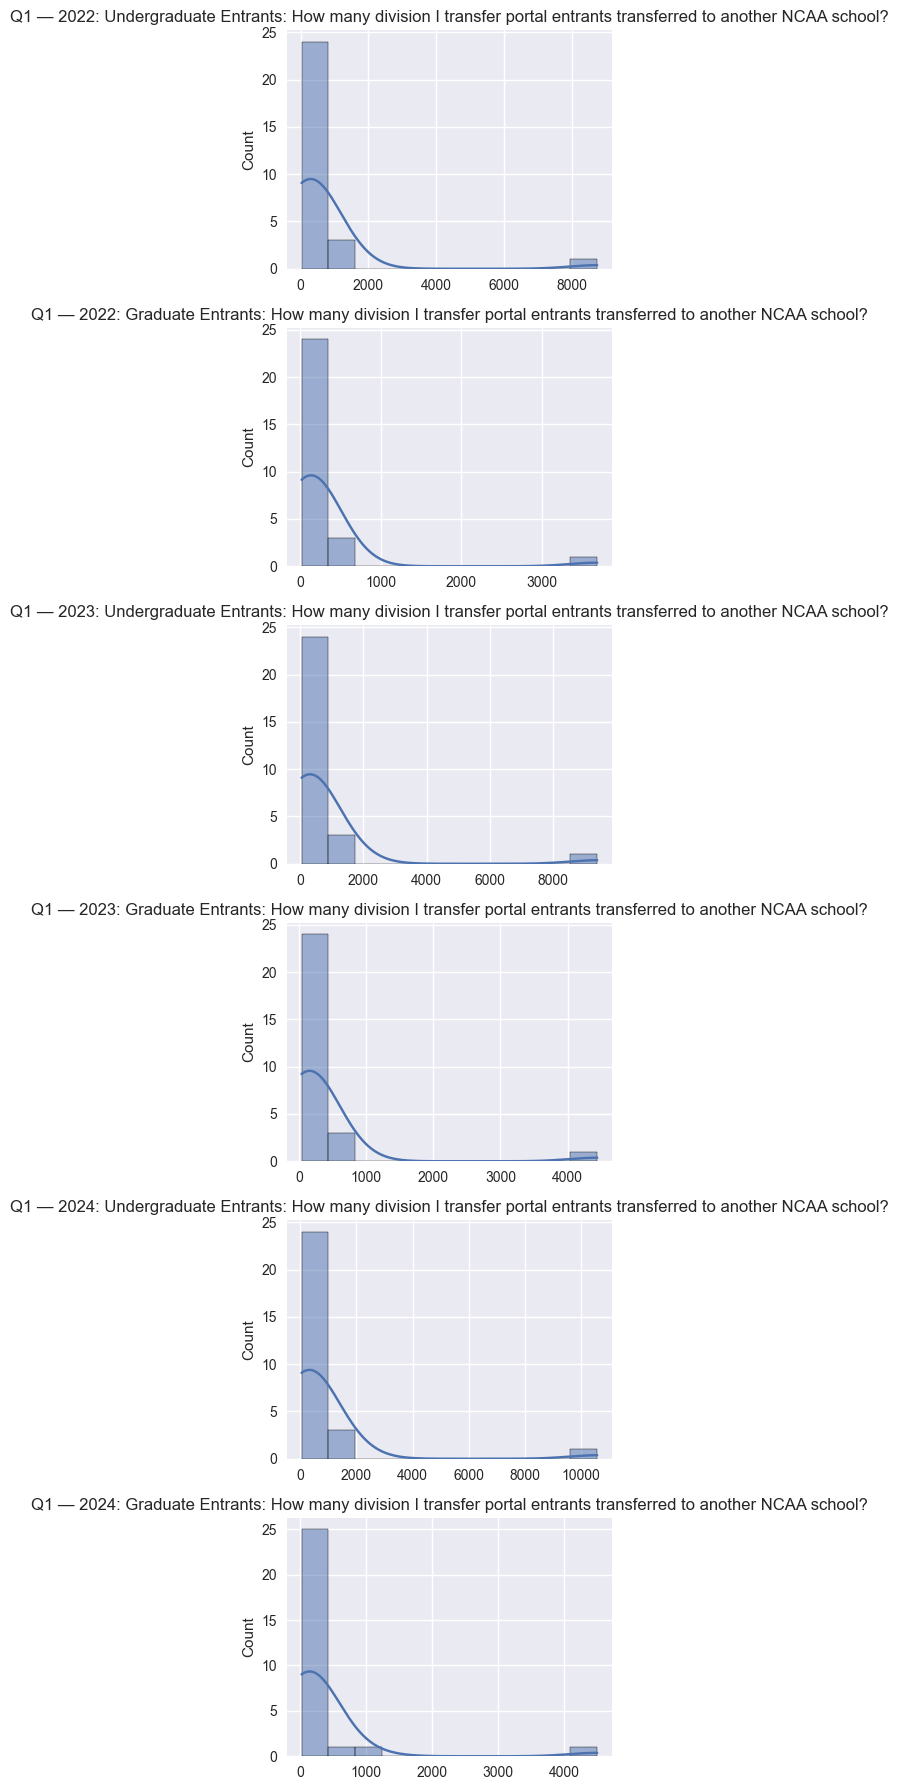

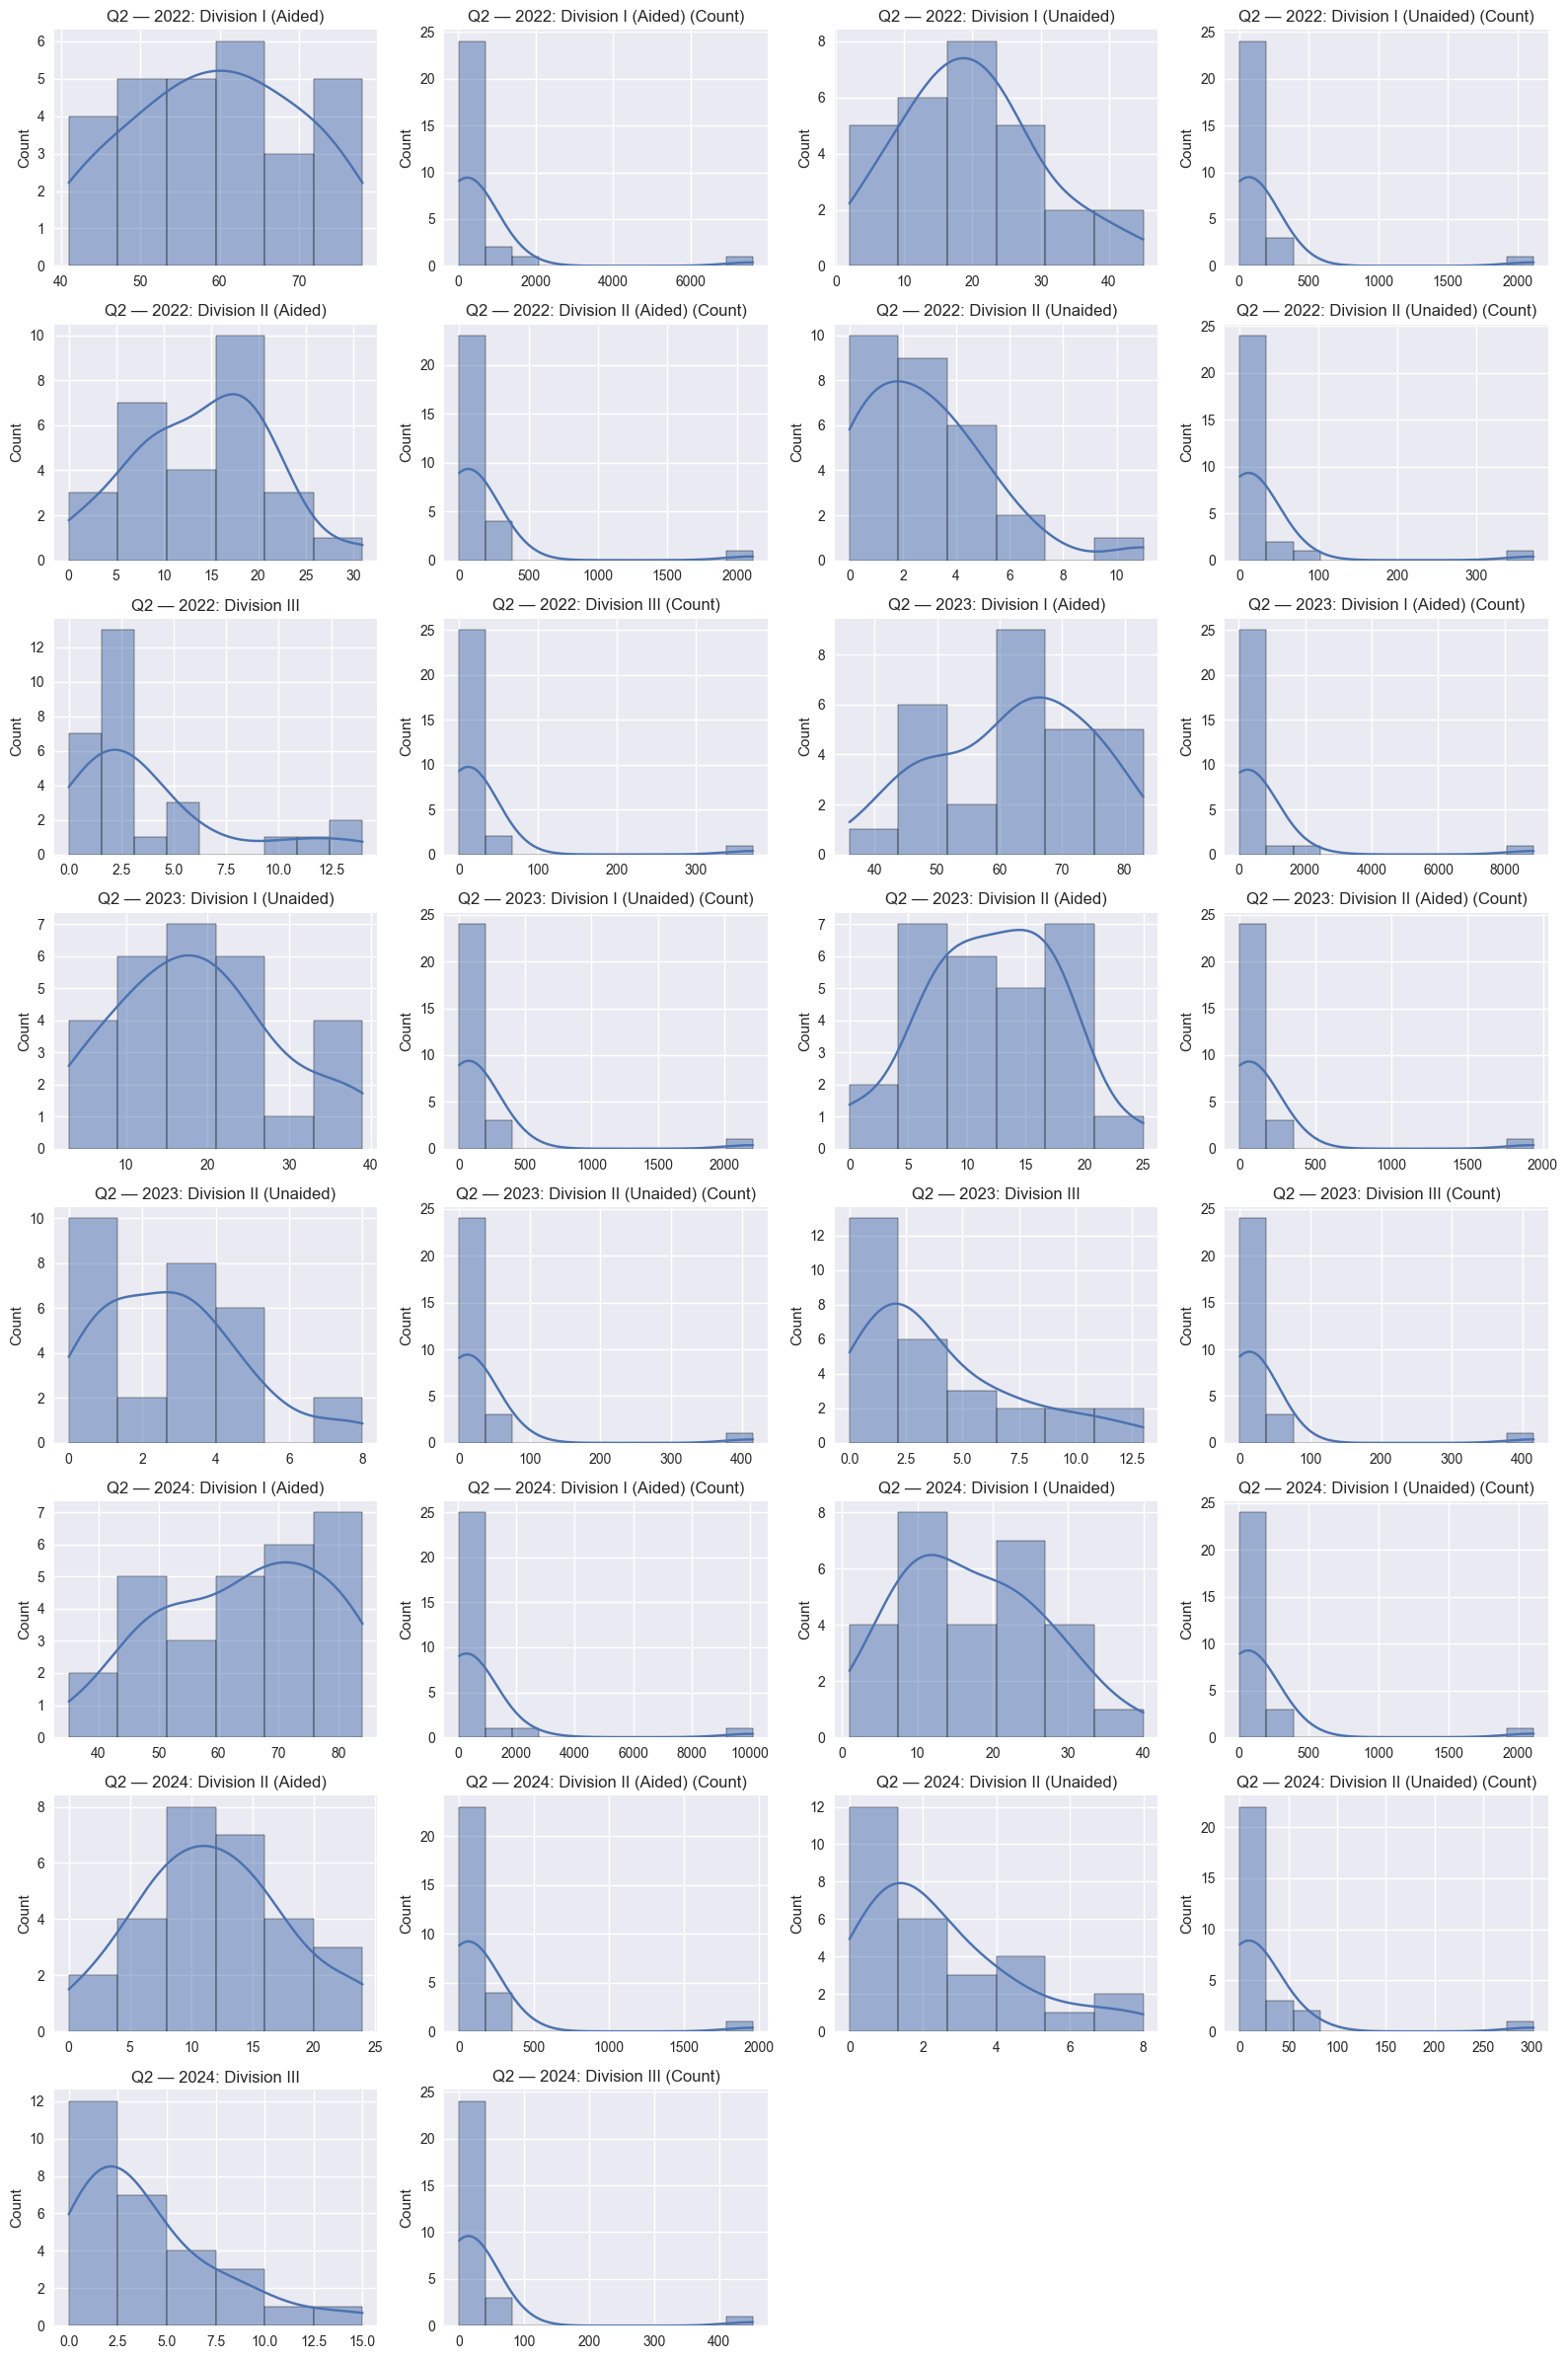

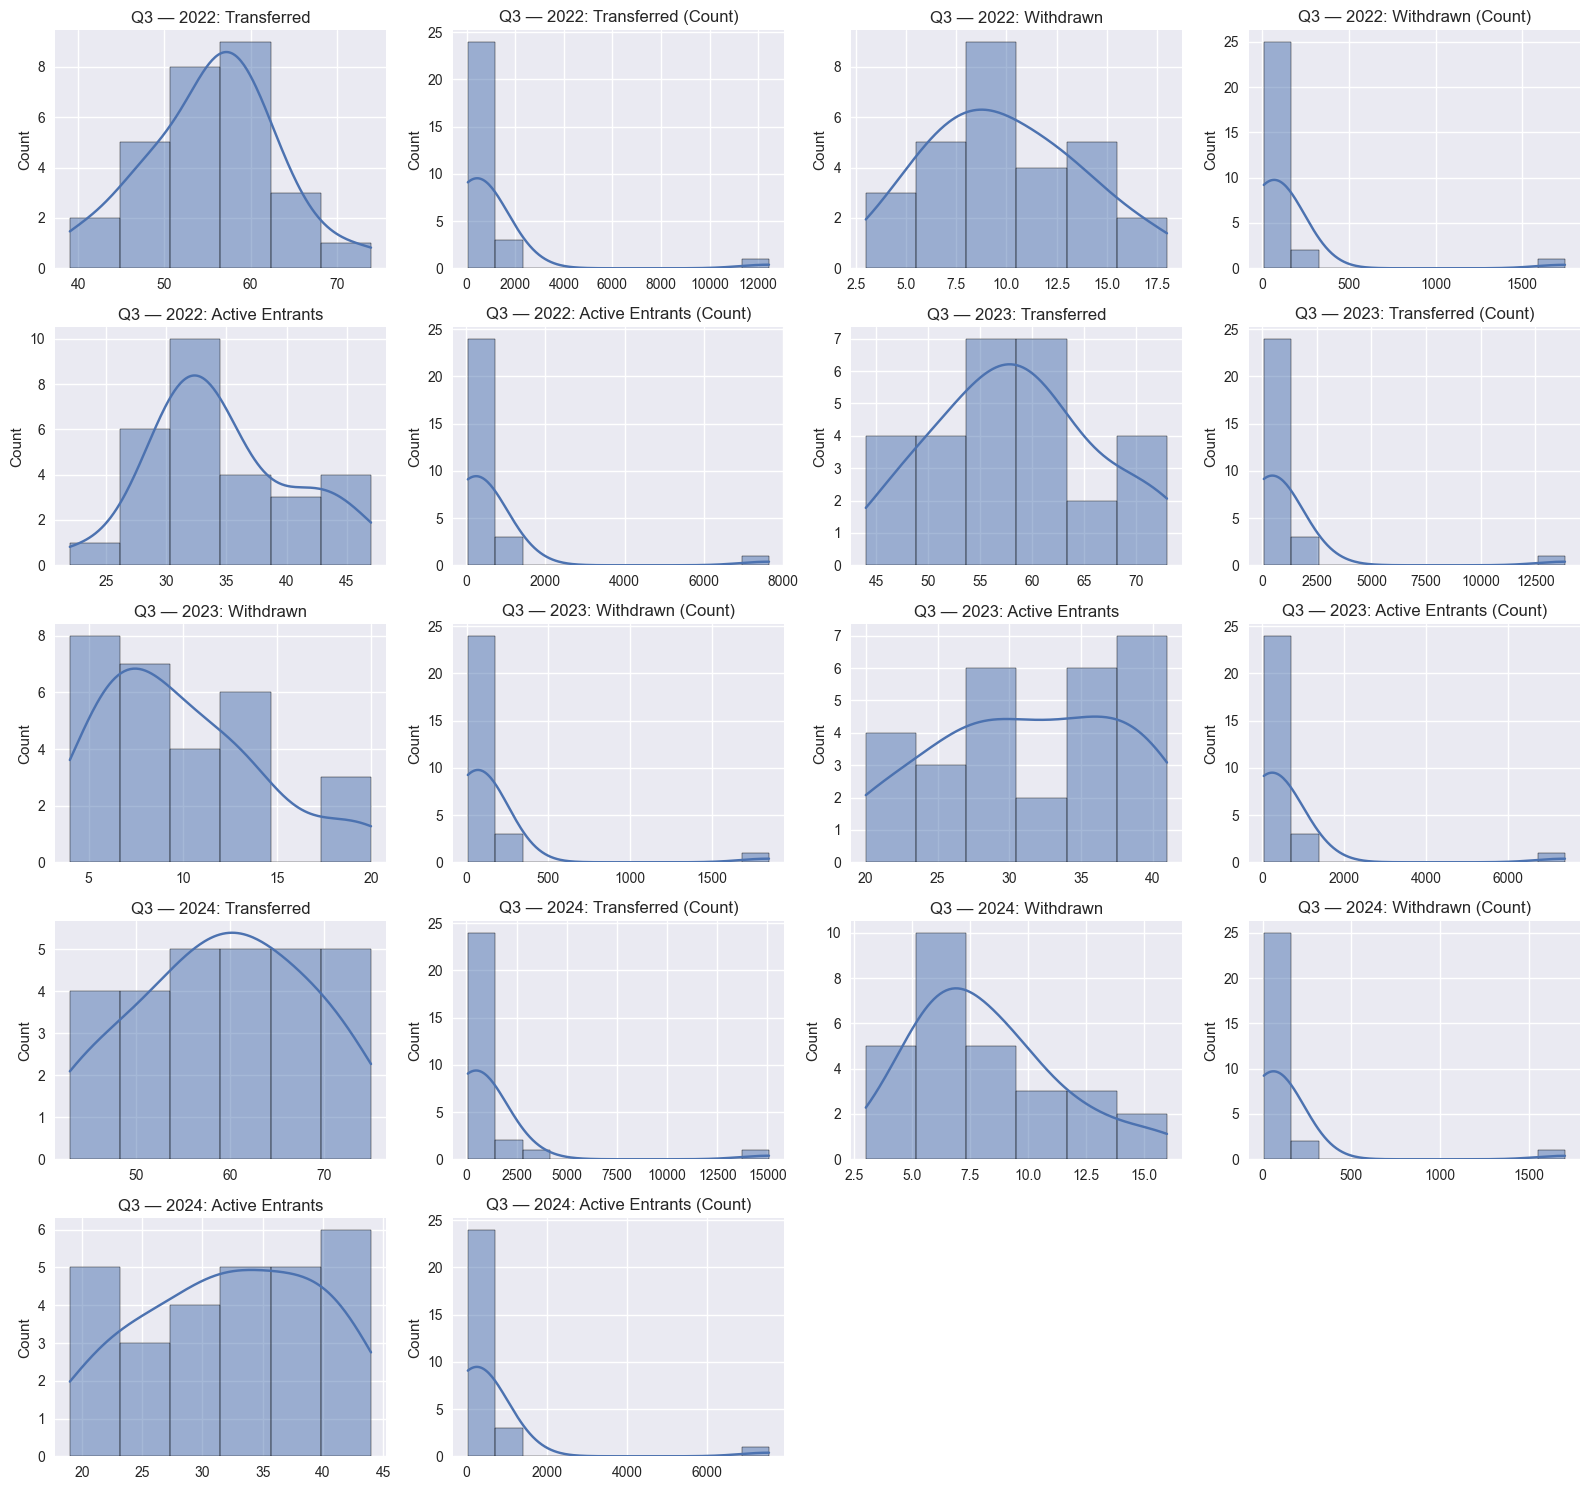

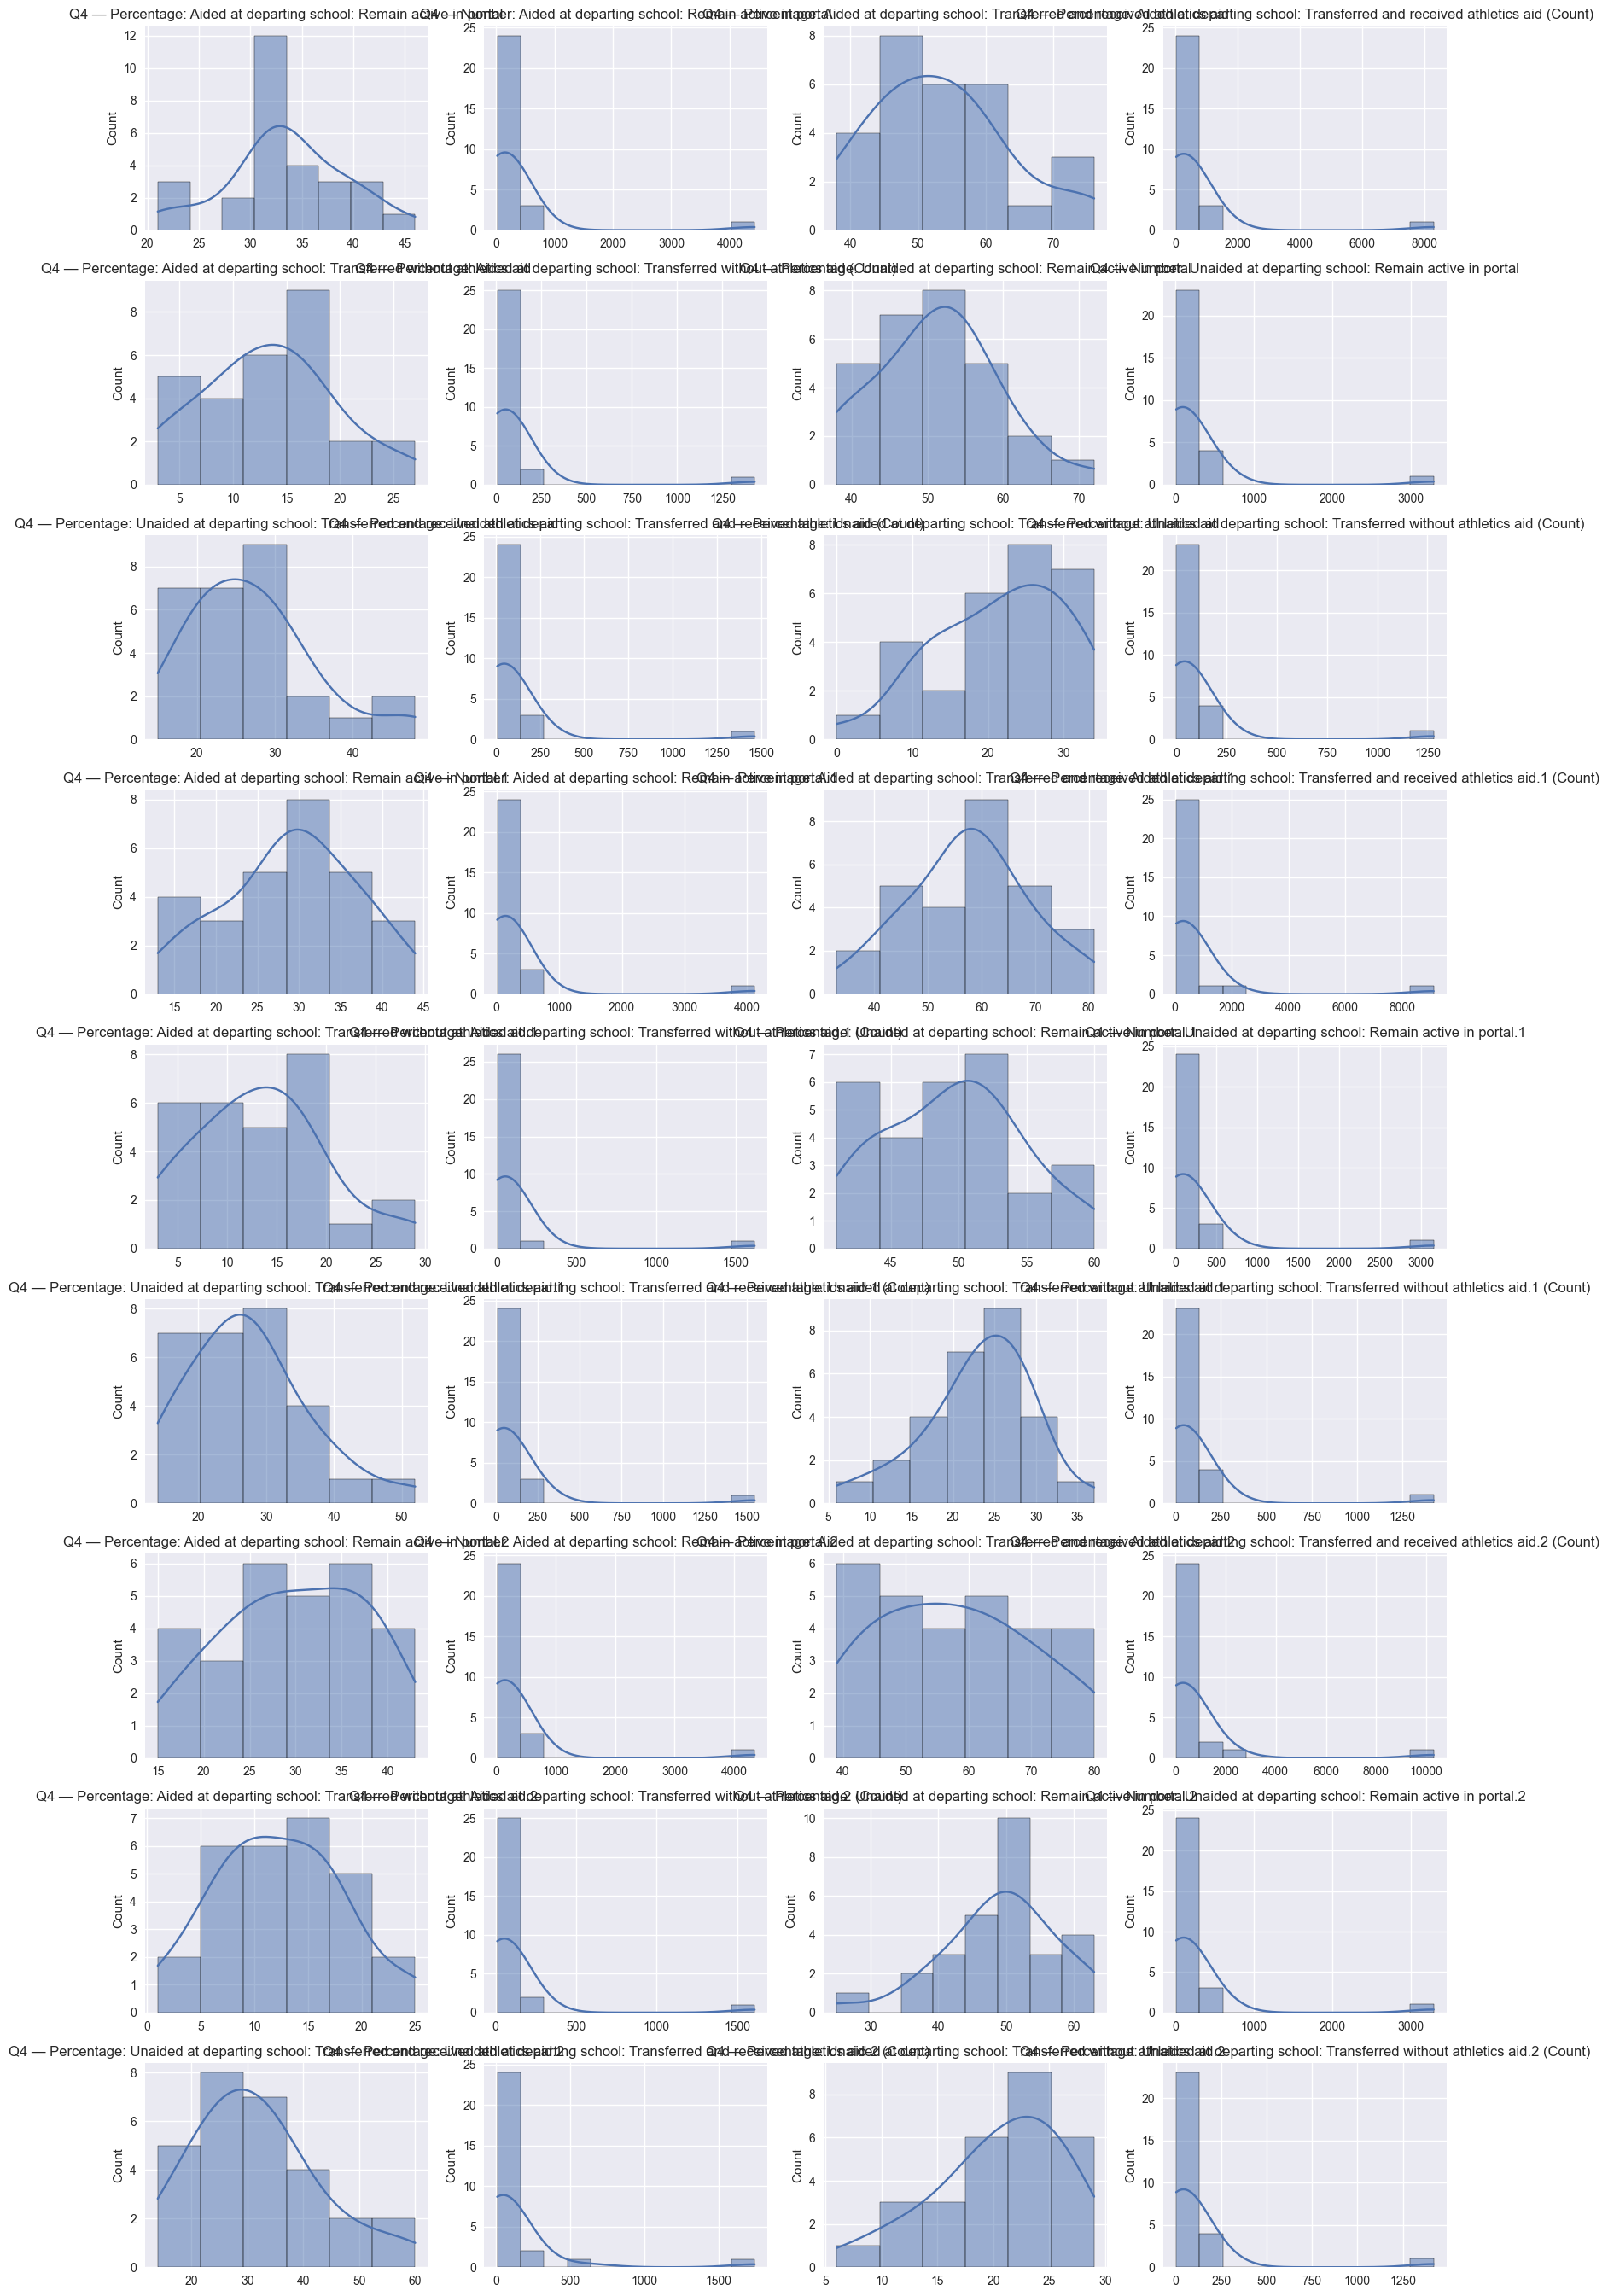

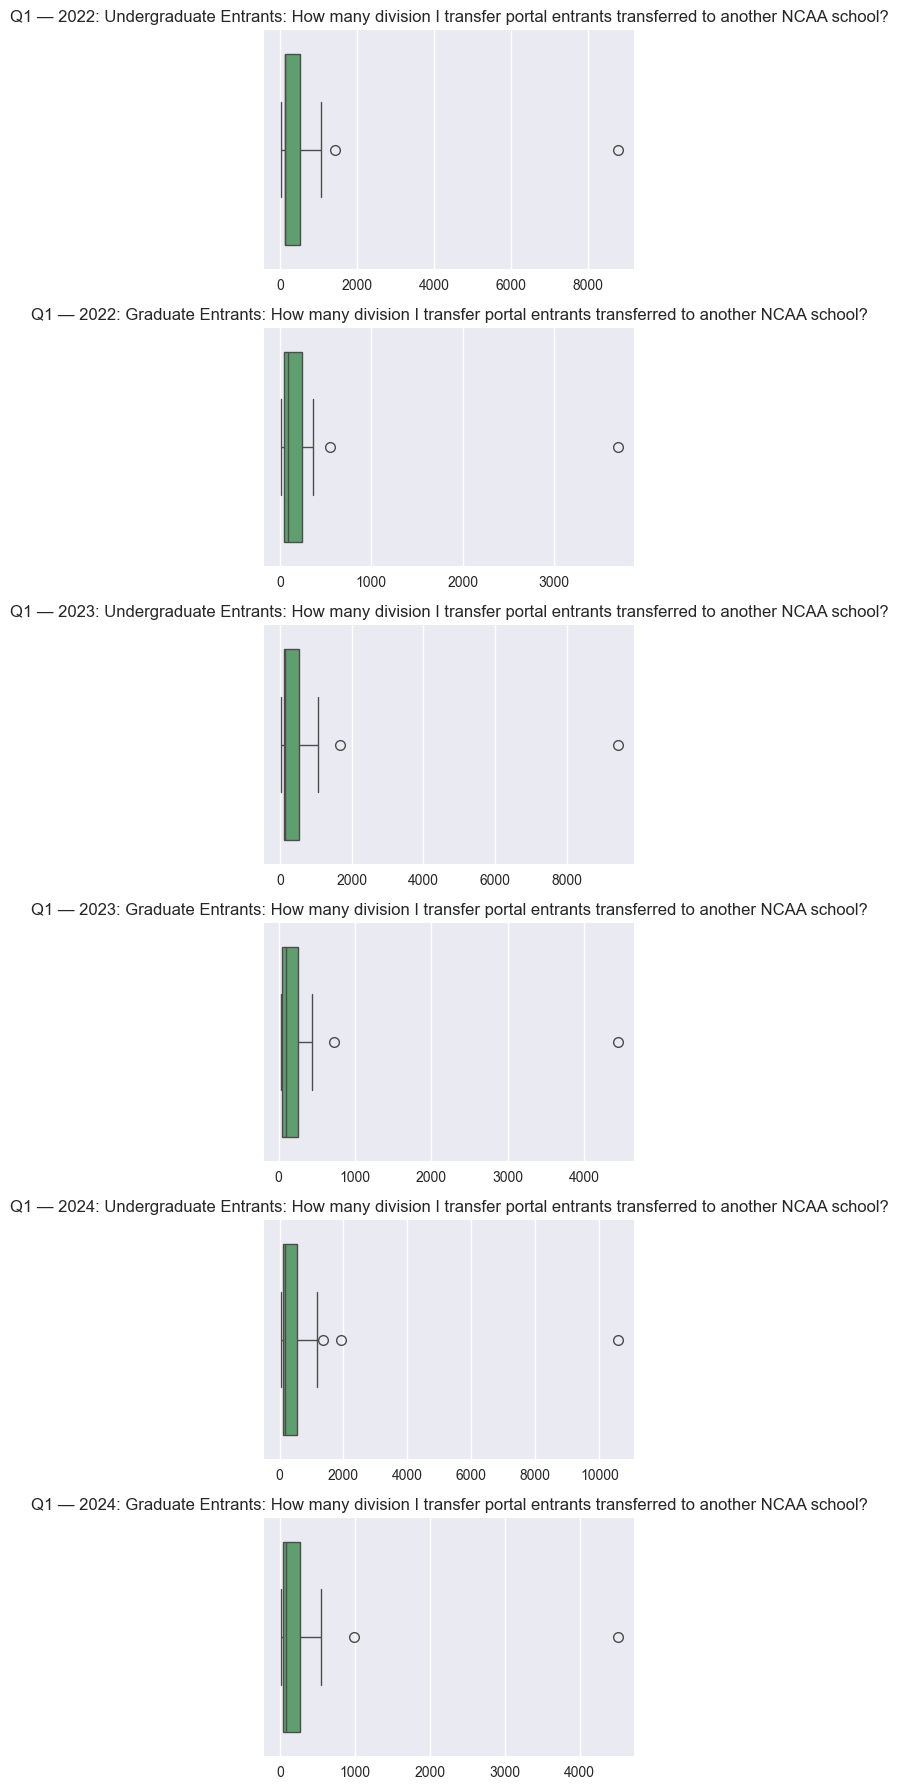

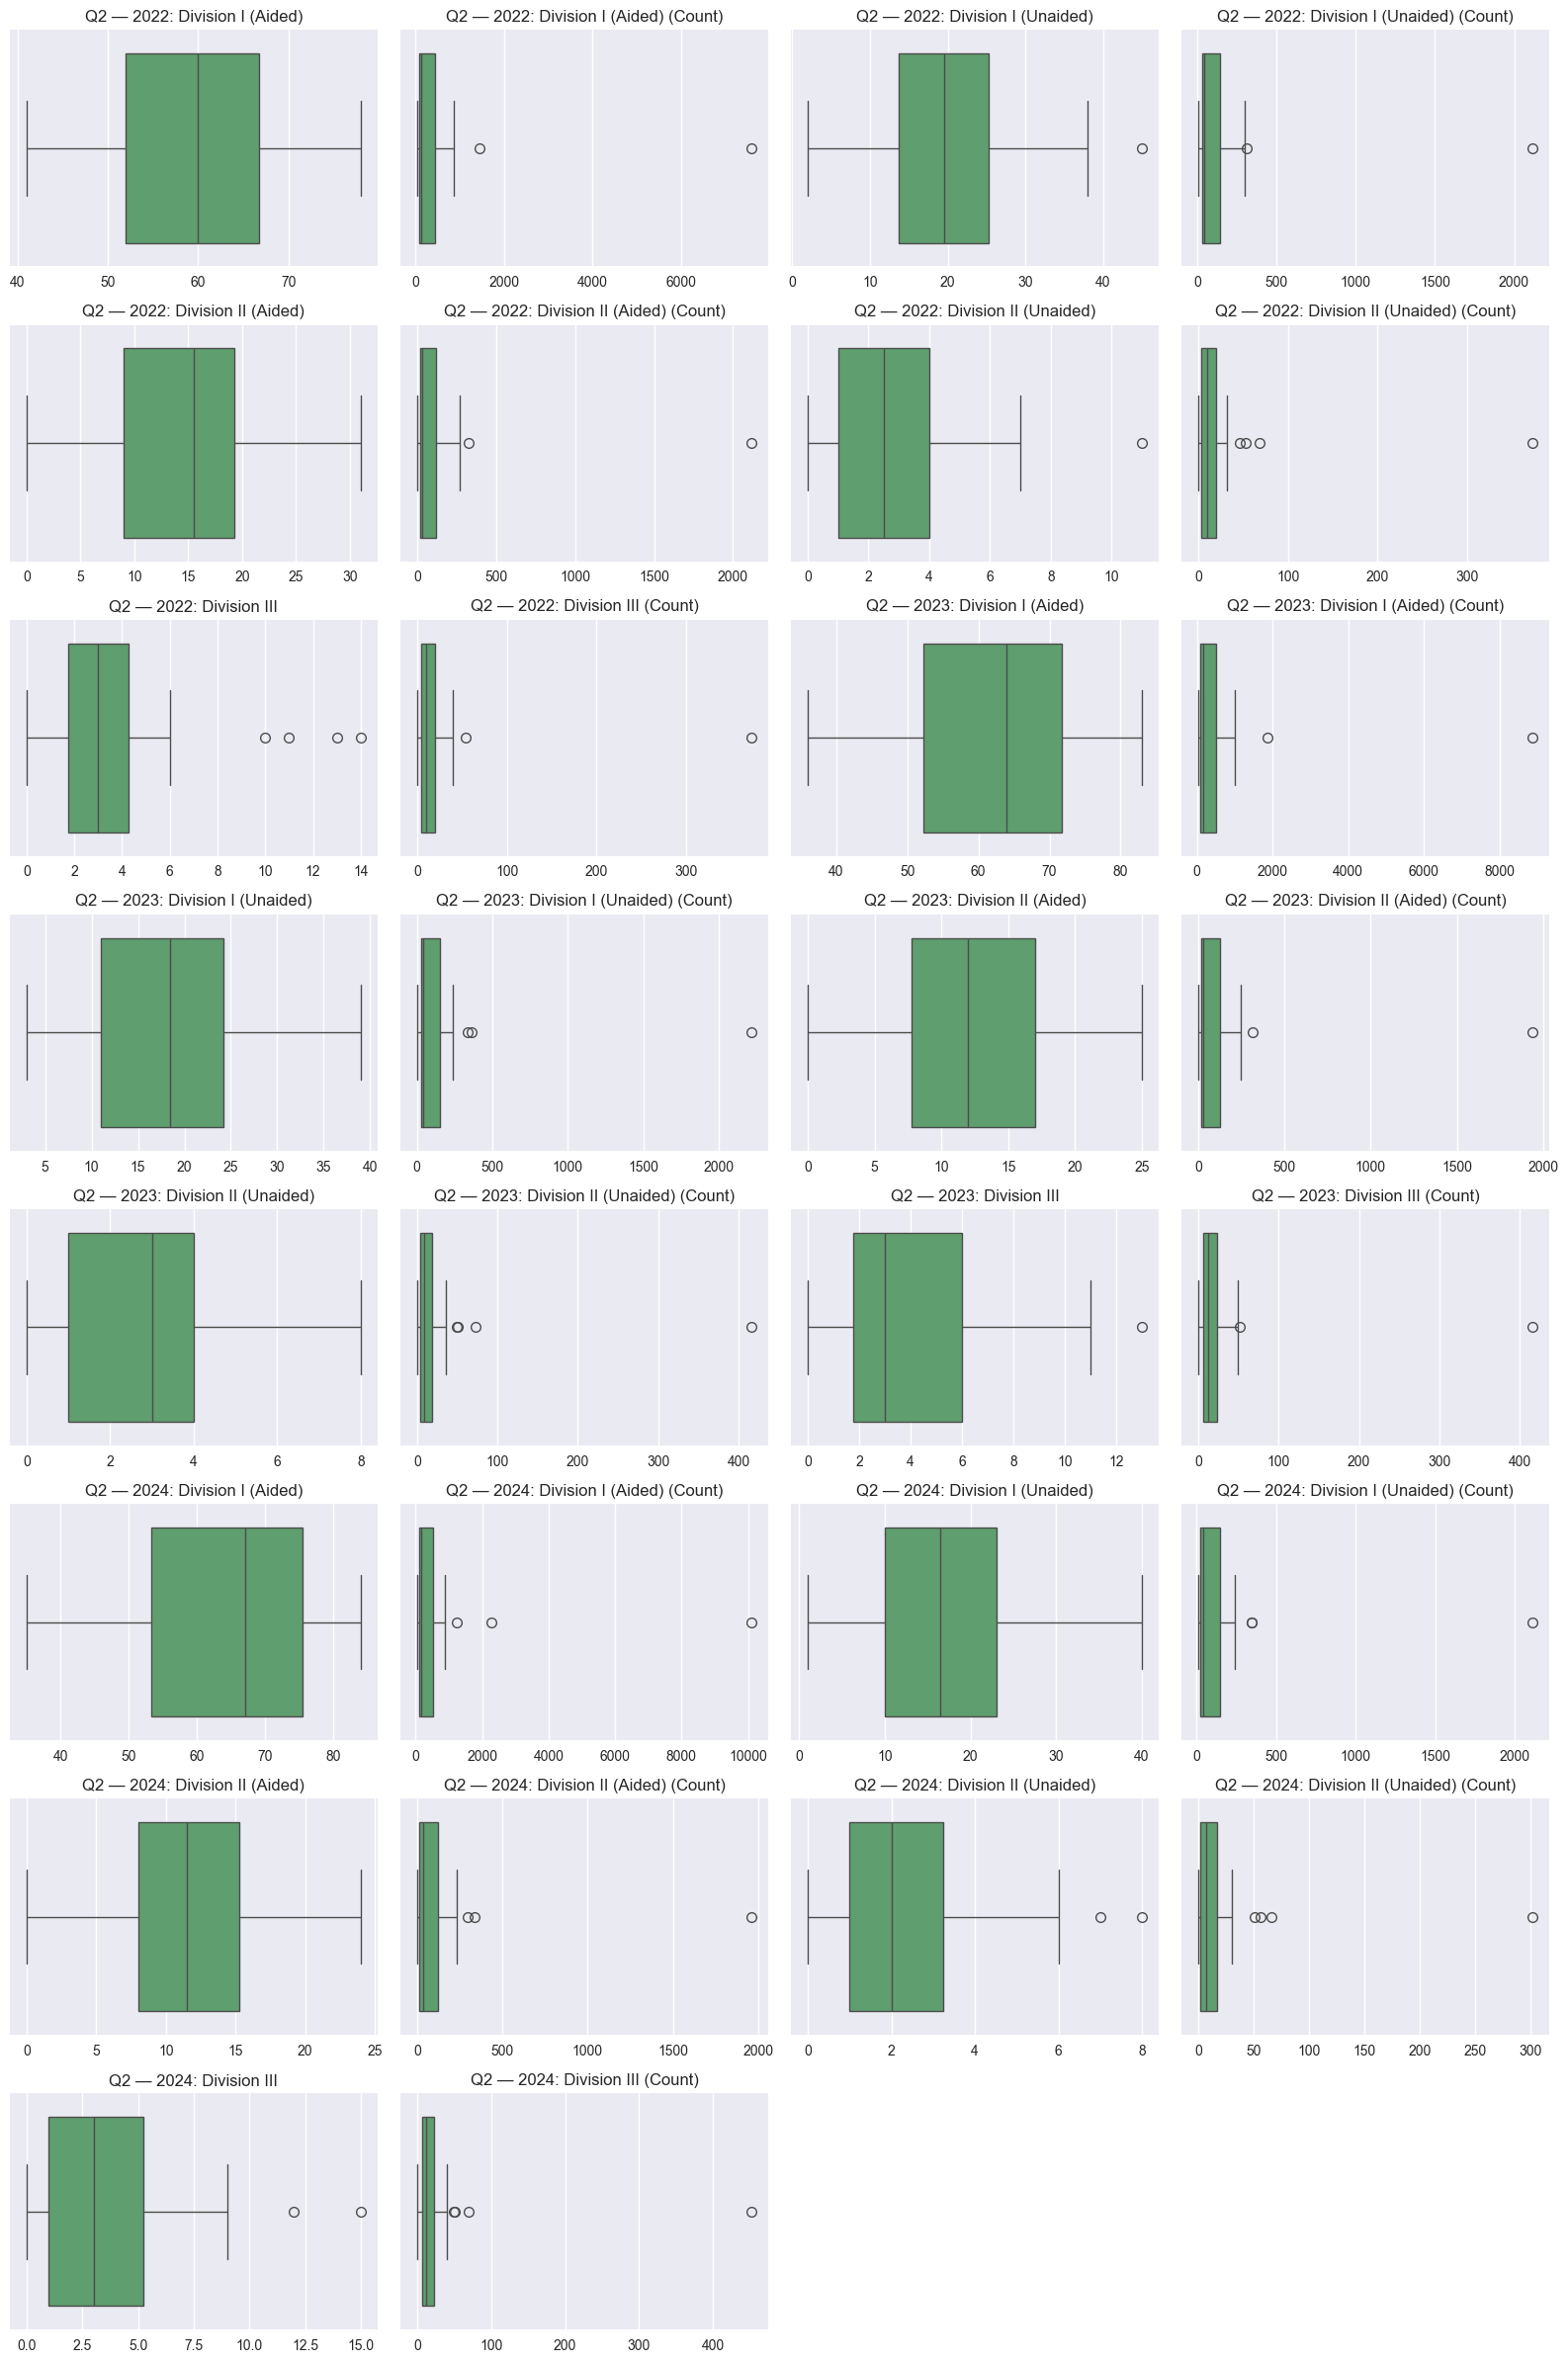

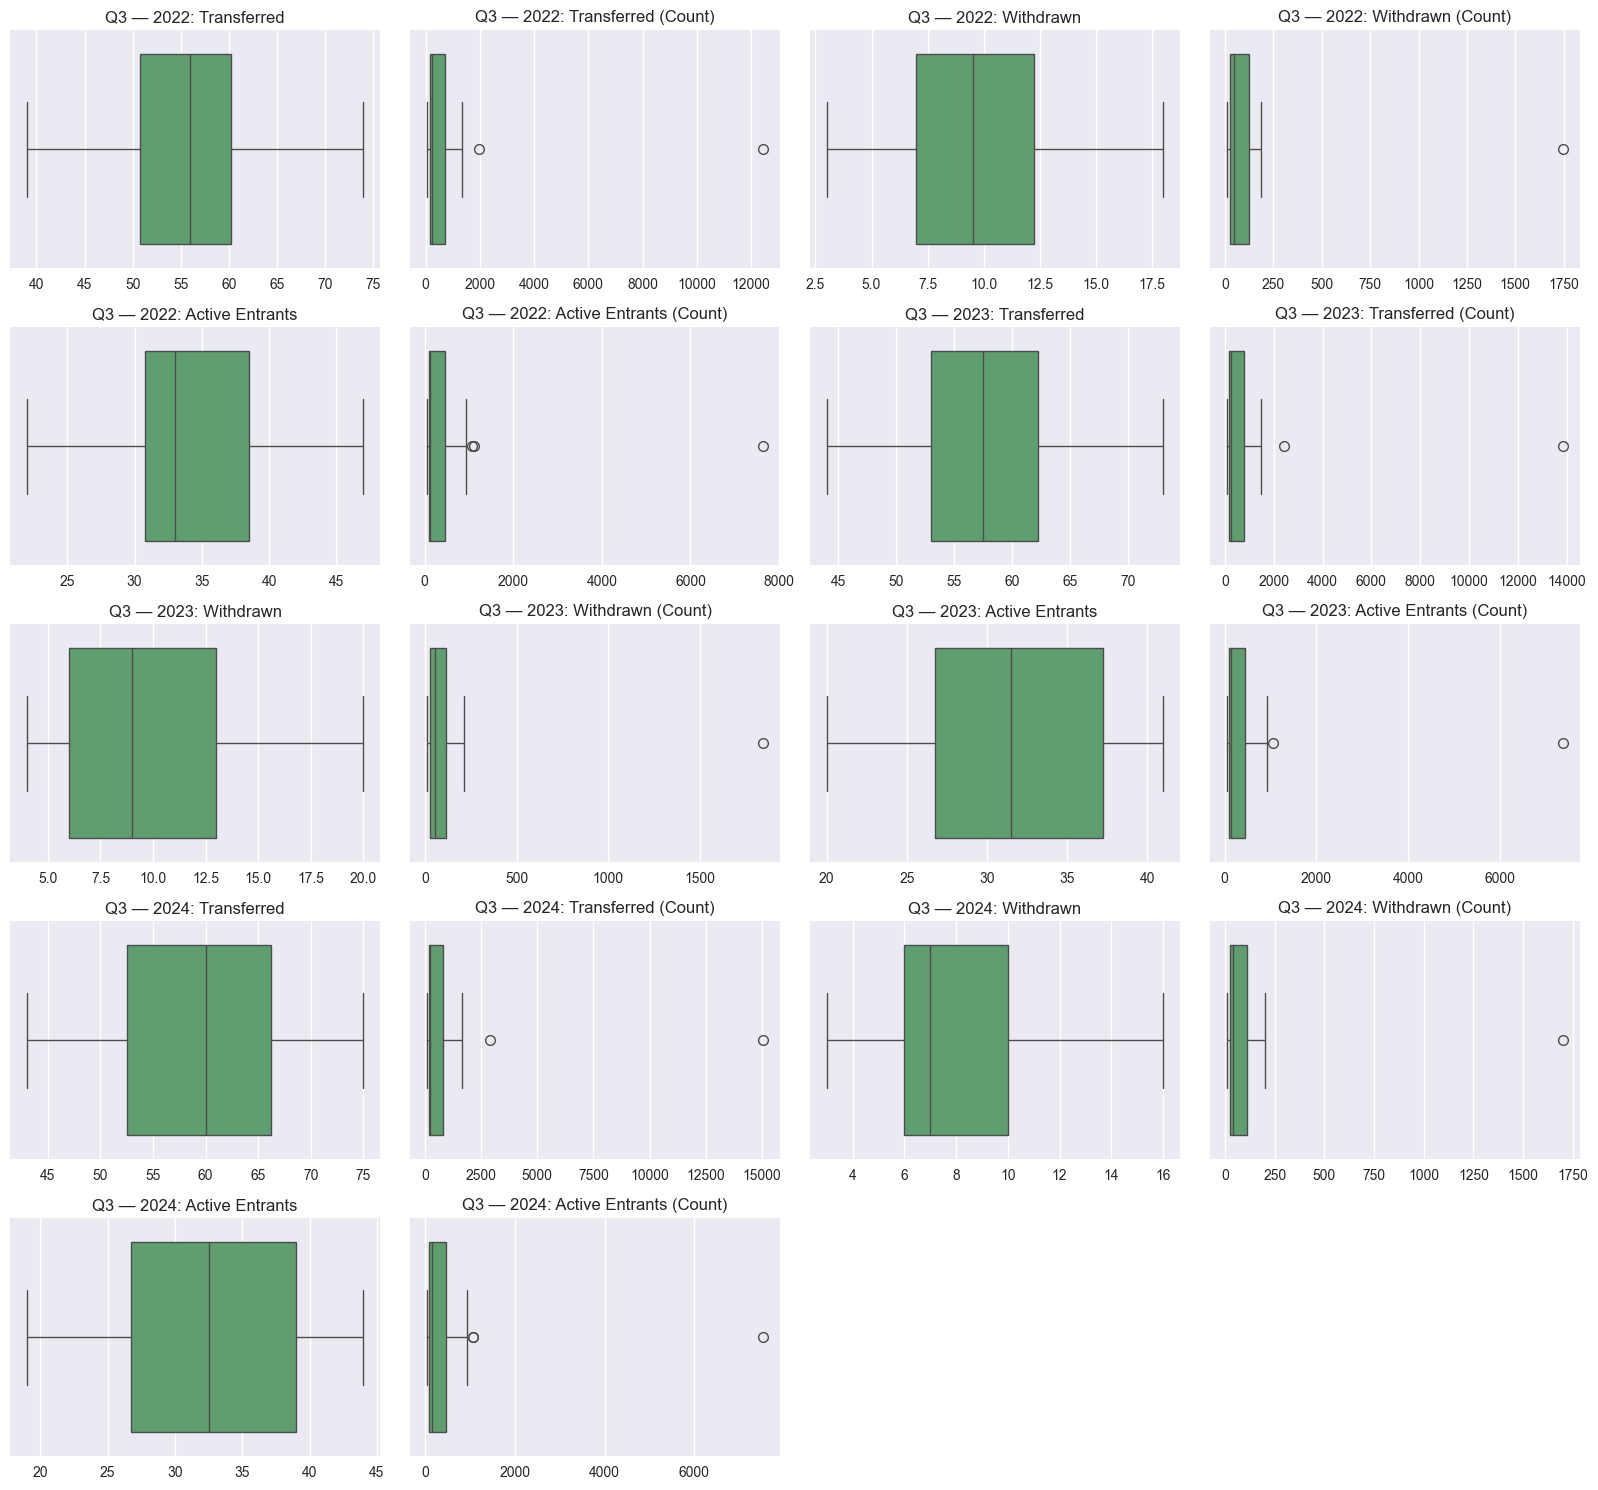

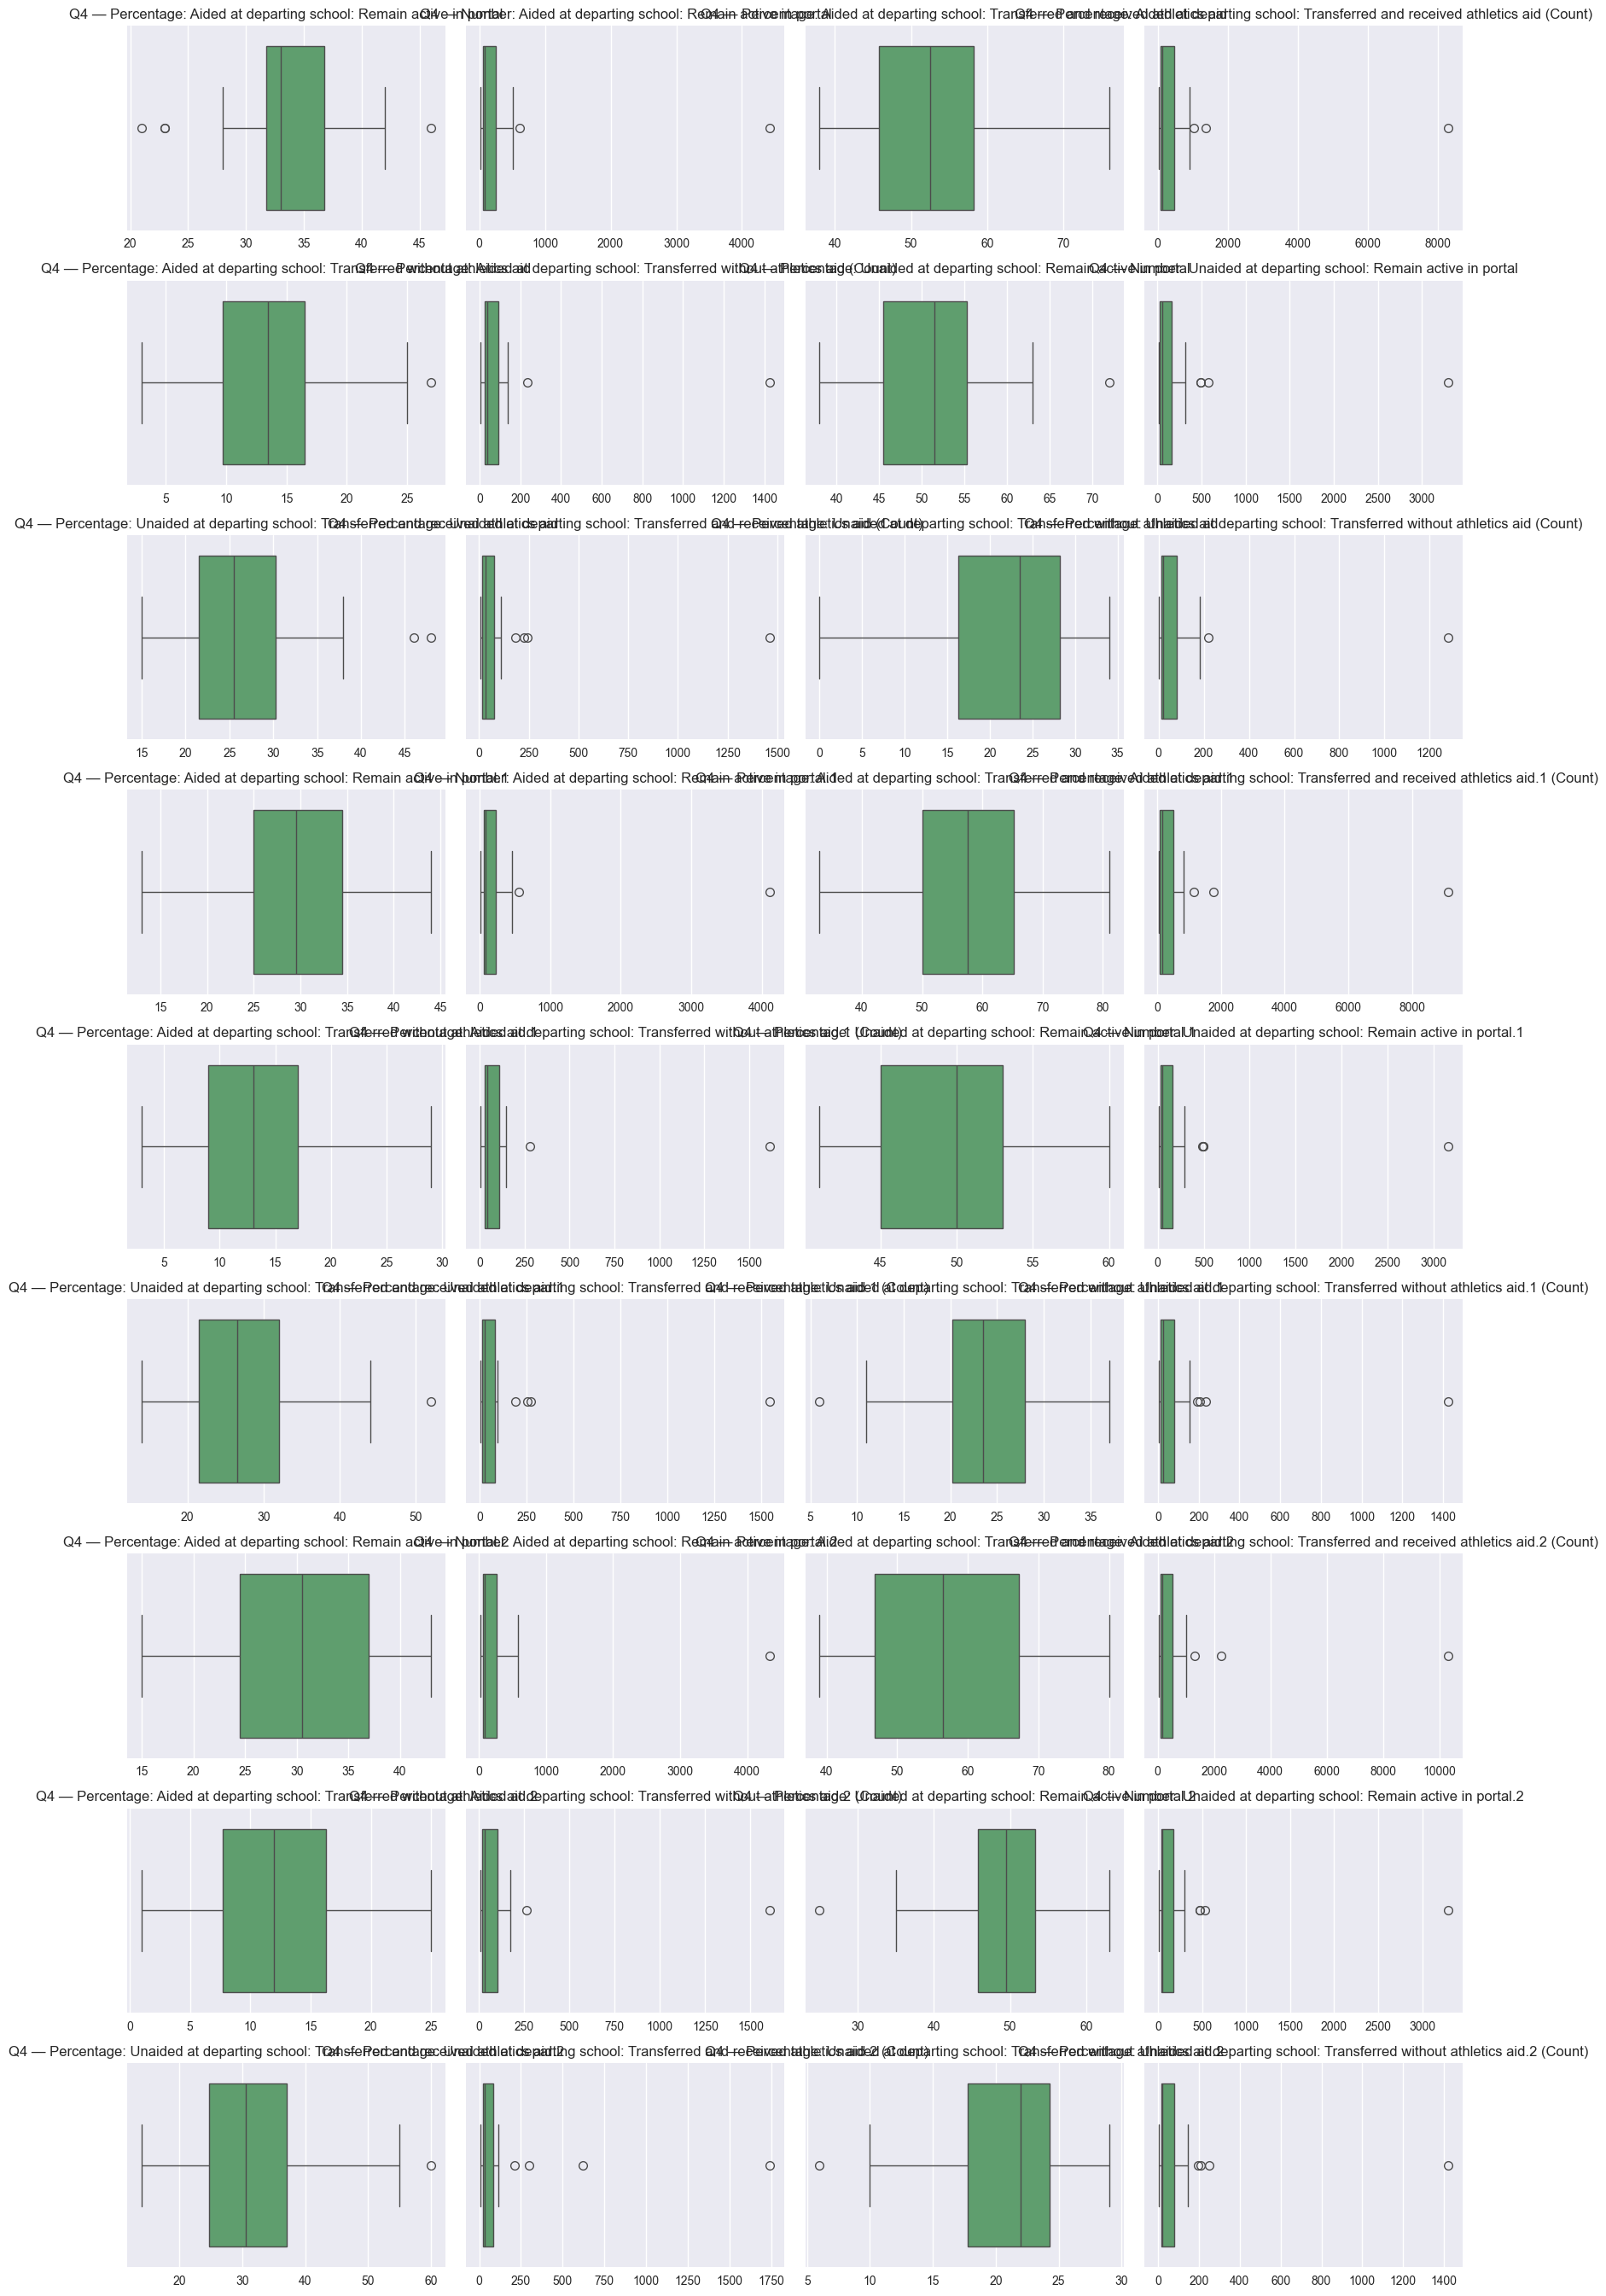

,dataset,column,sport,value,lower_bound,upper_bound
0,Q1,2022: Undergraduate Entrants: How many divisio...,All,8756,-509.375,1143.625
1,Q1,2022: Undergraduate Entrants: How many divisio...,Football-FBS,1427,-509.375,1143.625
2,Q1,2022: Graduate Entrants: How many division I t...,All,3692,-240.500,523.500
3,Q1,2022: Graduate Entrants: How many division I t...,Football-FBS,547,-240.500,523.500
4,Q1,2023: Undergraduate Entrants: How many divisio...,All,9411,-503.250,1136.750
...,...,...,...,...,...,...
145,Q4,Percentage: Unaided at departing school: Trans...,Women's Basketball,6,8.000,34.000
146,Q4,Percentage: Unaided at departing school: Trans...,All,1420,-82.750,175.250
147,Q4,Percentage: Unaided at departing school: Trans...,Baseball,194,-82.750,175.250
148,Q4,Percentage: Unaided at departing school: Trans...,Football-FBS,248,-82.750,175.250


In [7]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

plt.style.use("seaborn-v0_8")

def summarize_numeric(df: pd.DataFrame, label: str) -> pd.DataFrame:
    numeric = df.select_dtypes(include=[np.number])
    summary = numeric.agg(
        ["count", "mean", "median", "std", "min", "max"]
    ).transpose()
    summary.insert(0, "dataset", label)
    return summary

stats_tables = []
for name, frame in [
    ("Q1", q1),
    ("Q2_with_counts", q2_with_counts),
    ("Q3_with_counts", q3_with_counts),
    ("Q4_with_counts", q4_with_counts),
]:
    stats_tables.append(summarize_numeric(frame, name))

summary_stats = pd.concat(stats_tables)
display(summary_stats)

def plot_distributions(
    df: pd.DataFrame,
    label: str,
    kind: str = "hist",
    cols_per_fig: int = 4,
):
    numeric = df.select_dtypes(include=[np.number])
    if numeric.empty:
        return

    cols = max(1, min(cols_per_fig, numeric.shape[1]))
    rows = math.ceil(numeric.shape[1] / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), squeeze=False)
    axes_iter = axes.flatten()

    for ax, col in zip(axes_iter, numeric.columns):
        data = numeric[col].dropna()
        if kind == "hist":
            sns.histplot(data, kde=True, ax=ax, color="#4C72B0")
        else:
            sns.boxplot(x=data, ax=ax, color="#55A868")
        ax.set_title(f"{label} — {col}")
        ax.set_xlabel("")

    for ax in axes_iter[len(numeric.columns):]:
        ax.set_visible(False)

    fig.tight_layout()
    plt.show()

# Q1 plots now one-per-row (cols_per_fig=1)
plot_distributions(q1, "Q1", kind="hist", cols_per_fig=1)
plot_distributions(q2_with_counts, "Q2", kind="hist")
plot_distributions(q3_with_counts, "Q3", kind="hist")
plot_distributions(q4_with_counts, "Q4", kind="hist")

plot_distributions(q1, "Q1", kind="box", cols_per_fig=1)
plot_distributions(q2_with_counts, "Q2", kind="box")
plot_distributions(q3_with_counts, "Q3", kind="box")
plot_distributions(q4_with_counts, "Q4", kind="box")

def detect_outliers(df: pd.DataFrame, label: str, thresh: float = 1.5) -> pd.DataFrame:
    numeric = df.select_dtypes(include=[np.number])
    summary = []

    for col in numeric.columns:
        series = numeric[col].dropna()
        if series.empty:
            continue
        q1_val = series.quantile(0.25)
        q3_val = series.quantile(0.75)
        iqr = q3_val - q1_val
        lower = q1_val - thresh * iqr
        upper = q3_val + thresh * iqr
        mask = (series < lower) | (series > upper)

        if mask.any():
            summary.append(
                pd.DataFrame({
                    "dataset": label,
                    "column": col,
                    "sport": series.index[mask],
                    "value": series[mask],
                    "lower_bound": lower,
                    "upper_bound": upper,
                })
            )

    if summary:
        return pd.concat(summary, ignore_index=True)
    return pd.DataFrame(columns=["dataset", "column", "sport", "value", "lower_bound", "upper_bound"])

outliers = pd.concat(
    [
        detect_outliers(q1.set_index("Sport"), "Q1"),
        detect_outliers(q2_with_counts.set_index("Sport"), "Q2"),
        detect_outliers(q3_with_counts.set_index("Sport"), "Q3"),
        detect_outliers(q4_with_counts.set_index("Sport"), "Q4"),
    ],
    ignore_index=True,
)
display(outliers)


In [8]:
import re
from pathlib import Path
import pandas as pd
import numpy as np

# Load all sheets from the NCAA Excel workbook
workbook_path = Path("NCAA_Transfer_Portal_Data.xlsx")

if not workbook_path.exists():
    print(f"ERROR: File '{workbook_path}' not found in the working directory.")
    print(f"Current working directory: {Path.cwd()}")
else:
    sheets = pd.read_excel(workbook_path, sheet_name=None)
    
    for sheet_name, df in sheets.items():
        print("\n" + "="*80)
        print(f"SHEET: {sheet_name}")
        print("="*80)
        
        # ===================================================================
        # 1) MISSING VALUES
        # ===================================================================
        print(f"\n=== {sheet_name} • MISSING VALUES ===")
        print("-"*80)
        
        total_rows = len(df)
        rows_with_missing = df.isna().any(axis=1).sum()
        missing_pct = (rows_with_missing / total_rows * 100) if total_rows > 0 else 0
        
        print(f"Total Rows: {total_rows}")
        print(f"Rows with Any Missing: {rows_with_missing} ({missing_pct:.1f}%)")
        print()
        
        # Build missing value summary DataFrame
        missing_records = []
        for col in df.columns:
            series = df[col]
            missing_count = series.isna().sum()
            missing_pct_col = (missing_count / total_rows * 100) if total_rows > 0 else 0
            unique_count = series.nunique(dropna=False)
            
            # Get up to 3 non-null examples
            non_null_vals = series.dropna().head(3).tolist()
            examples = str(non_null_vals) if non_null_vals else "[]"
            
            missing_records.append({
                "variable": col,
                "dtype": str(series.dtype),
                "missing_count": missing_count,
                "missing_pct": round(missing_pct_col, 2),
                "unique_values": unique_count,
                "examples": examples
            })
        
        missing_df = pd.DataFrame(missing_records).sort_values("missing_pct", ascending=False)
        print(missing_df.to_string(index=False))
        
        # ===================================================================
        # 2) INCONSISTENCIES
        # ===================================================================
        print(f"\n=== {sheet_name} • INCONSISTENCIES ===")
        print("-"*80)
        
        # Check Sport column if present
        if "Sport" in df.columns:
            sport_series = df["Sport"].astype(str)
            
            leading_trailing_spaces = (sport_series != sport_series.str.strip()).sum()
            double_spaces = sport_series.str.contains(r'\s{2,}', regex=True).sum()
            non_ascii = sport_series.str.contains(r'[^\x00-\x7F]', regex=True).sum()
            
            unique_original = sport_series.nunique()
            unique_lower = sport_series.str.lower().nunique()
            case_variation_hint = unique_original - unique_lower
            
            print("Sport Column Quality:")
            print(f"  Leading/Trailing Spaces: {leading_trailing_spaces}")
            print(f"  Double Spaces: {double_spaces}")
            print(f"  Non-ASCII Characters: {non_ascii}")
            print(f"  Case Variation (unique - unique_lower): {case_variation_hint}")
            print()
        
        # Check for numeric-like text inconsistencies
        pct_columns = []
        comma_columns = []
        other_nonnumeric = []
        
        for col in df.columns:
            if df[col].dtype == object:
                col_str = df[col].astype(str)
                
                # Check for percentage symbols
                if col_str.str.contains('%', na=False).any():
                    pct_columns.append(col)
                
                # Check for comma-formatted numbers
                if col_str.str.contains(r'\d,\d', regex=True, na=False).any():
                    comma_columns.append(col)
                
                # Check for other non-numeric chars in numeric-looking data
                # (exclude % and comma which we already caught)
                if col_str.str.contains(r'[^\d.,\-%\s]', regex=True, na=False).any():
                    other_nonnumeric.append(col)
        
        print("Numeric-like Text Issues:")
        print(f"  Columns with '%': {pct_columns if pct_columns else 'None'}")
        print(f"  Columns with Comma Numbers: {comma_columns if comma_columns else 'None'}")
        print(f"  Columns with Other Non-Numeric Chars: {other_nonnumeric if other_nonnumeric else 'None'}")
        print()
        
        # Check headers
        year_stamped_cols = [col for col in df.columns if re.search(r'20\d{2}', str(col))]
        
        # Numeric-as-text suspects: object dtype but can convert to numeric
        numeric_as_text = []
        for col in df.columns:
            if df[col].dtype == object and col != "Sport":
                try:
                    # Try converting after removing common formatting
                    test_series = df[col].astype(str).str.replace(',', '').str.rstrip('%')
                    pd.to_numeric(test_series, errors='raise')
                    numeric_as_text.append(col)
                except:
                    pass
        
        print("Header Issues:")
        print(f"  Year-Stamped Columns (contain 20xx): {year_stamped_cols if year_stamped_cols else 'None'}")
        print(f"  Numeric-as-Text Suspects (object dtype): {numeric_as_text if numeric_as_text else 'None'}")
        
        # ===================================================================
        # 3) DUPLICATES
        # ===================================================================
        print(f"\n=== {sheet_name} • DUPLICATES ===")
        print("-"*80)
        
        exact_duplicates = df.duplicated().sum()
        print(f"Exact Duplicate Rows: {exact_duplicates}")
        print()
        
        if "Sport" in df.columns:
            sport_counts = df["Sport"].value_counts()
            repeated_sports = sport_counts[sport_counts > 1]
            
            if len(repeated_sports) > 0:
                print("Repeated Sport Values (Top 10):")
                print(repeated_sports.head(10).to_string())
            else:
                print("No Repeated Sport Values (each sport appears once)")
            print()
        
        print("Proposed Keys:")
        print(f"  Current Sheet Key: ['Sport'] (if present)")
        print(f"  Long-Form After Reshape: ['sport', 'year', 'measure']")
        
        # ===================================================================
        # 4) TRANSFORMATION REQUIREMENTS
        # ===================================================================
        print(f"\n=== {sheet_name} • TRANSFORMATION REQUIREMENTS ===")
        print("-"*80)
        
        requirements = []
        
        # Numeric conversion needs
        if numeric_as_text or pct_columns or comma_columns:
            requirements.append("• Convert numeric-as-text: strip commas and '%' symbols, then convert to numeric dtype")
        
        # Sport standardization
        if "Sport" in df.columns and (leading_trailing_spaces > 0 or double_spaces > 0 or case_variation_hint > 0):
            requirements.append("• Standardize 'Sport' labels: trim whitespace, collapse double spaces, apply title case")
        
        # Reshape wide to long
        if year_stamped_cols:
            requirements.append("• Reshape year-stamped columns from wide to long format")
            requirements.append("• Create tidy schema: [sport, year, measure, value]")
        
        # Denominator definition
        if sheet_name in ["Q2", "Q3", "Q4"]:
            requirements.append("• Define clear denominators: use Q1 totals (graduate + undergraduate) as rate denominators")
            requirements.append("• Compute counts from percentages: count = (percentage / 100) × denominator")
        
        if not requirements:
            requirements.append("• No major transformations needed; data appears clean")
        
        for req in requirements:
            print(req)
        
        print()

    print("\n" + "="*80)
    print("DATA CLEANING DIAGNOSTICS COMPLETE")
    print("="*80)


SHEET: Q1

=== Q1 • MISSING VALUES ===
--------------------------------------------------------------------------------
Total Rows: 28
Rows with Any Missing: 0 (0.0%)

                                                                                                      variable  dtype  missing_count  missing_pct  unique_values                                examples
                                                                                                         Sport object              0          0.0             28 ['All', 'Baseball', 'Beach Volleyball']
2022: Undergraduate Entrants: How many division I transfer portal entrants transferred to another NCAA school?  int64              0          0.0             25                        [8756, 1052, 58]
     2022: Graduate Entrants: How many division I transfer portal entrants transferred to another NCAA school?  int64              0          0.0             27                         [3692, 298, 40]
2023: Undergraduate Entrant

In [9]:
import pandas as pd
import numpy as np

print("="*80)
print("CHECKING PROCESSED DATAFRAMES IN MEMORY")
print("="*80)

processed_dfs = {
    "q1": q1,
    "q2_with_counts": q2_with_counts,
    "q3_with_counts": q3_with_counts,
    "q4_with_counts": q4_with_counts
}

for name, df in processed_dfs.items():
    print(f"\n{'='*80}")
    print(f"DataFrame: {name}")
    print(f"{'='*80}")
    
    print(f"\nShape: {df.shape[0]} rows × {df.shape[1]} columns")
    
    # Missing values summary
    total_cells = df.shape[0] * df.shape[1]
    missing_cells = df.isna().sum().sum()
    missing_pct = (missing_cells / total_cells * 100) if total_cells > 0 else 0
    
    print(f"\nOverall Missing Data:")
    print(f"  Total cells: {total_cells:,}")
    print(f"  Missing cells: {missing_cells:,} ({missing_pct:.2f}%)")
    
    # Per-column breakdown
    print(f"\nPer-Column Missing Data:")
    col_missing = []
    for col in df.columns:
        missing_count = df[col].isna().sum()
        missing_pct_col = (missing_count / len(df) * 100) if len(df) > 0 else 0
        col_missing.append({
            "column": col,
            "dtype": str(df[col].dtype),
            "missing": missing_count,
            "missing_pct": round(missing_pct_col, 2),
            "non_null": len(df) - missing_count
        })
    
    col_missing_df = pd.DataFrame(col_missing).sort_values("missing_pct", ascending=False)
    
    # Only show columns with missing data
    cols_with_missing = col_missing_df[col_missing_df["missing"] > 0]
    
    if len(cols_with_missing) > 0:
        print(f"\n⚠️  {len(cols_with_missing)} columns have missing data:")
        print(cols_with_missing.to_string(index=False))
    else:
        print("\n✅ No missing data in any column!")
    
    # Data type summary
    print(f"\nData Types:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  {dtype}: {count} columns")
    
    # Sample of data
    print(f"\nFirst 3 rows:")
    print(df.head(3).to_string())

print(f"\n{'='*80}")
print("PROCESSED DATAFRAMES CHECK COMPLETE")
print(f"{'='*80}")

CHECKING PROCESSED DATAFRAMES IN MEMORY

DataFrame: q1

Shape: 28 rows × 7 columns

Overall Missing Data:
  Total cells: 196
  Missing cells: 0 (0.00%)

Per-Column Missing Data:

✅ No missing data in any column!

Data Types:
  int64: 6 columns
  object: 1 columns

First 3 rows:
              Sport  2022: Undergraduate Entrants: How many division I transfer portal entrants transferred to another NCAA school?  2022: Graduate Entrants: How many division I transfer portal entrants transferred to another NCAA school?  2023: Undergraduate Entrants: How many division I transfer portal entrants transferred to another NCAA school?  2023: Graduate Entrants: How many division I transfer portal entrants transferred to another NCAA school?  2024: Undergraduate Entrants: How many division I transfer portal entrants transferred to another NCAA school?  2024: Graduate Entrants: How many division I transfer portal entrants transferred to another NCAA school?
0               All                         

In [25]:
import pandas as pd
import numpy as np
import re

print("="*80)
print("CREATING LONG-FORMAT COPIES OF DATAFRAMES")
print("="*80)

# Create copies to preserve originals
q1_long_format = q1.copy()
q2_long_format = q2_with_counts.copy()
q3_long_format = q3_with_counts.copy()
q4_long_format = q4_with_counts.copy()

# ============================================================================
# Q1: Reshape to [sport, year, level, athletes]
# ============================================================================
print("\n--- Reshaping Q1 ---")

# Extract year-stamped columns
q1_value_cols = [c for c in q1_long_format.columns if c != "Sport"]

# Infer years from column names
def infer_years(columns):
    year_counts = {}
    inferred = []
    last_year = None
    for col in columns:
        match = re.search(r"(\d{4})", col)
        year = int(match.group(1)) if match else last_year
        if year is None:
            raise ValueError(f"Could not infer year from column '{col}'")
        while year_counts.get(year, 0) >= 2:
            year += 1
        year_counts[year] = year_counts.get(year, 0) + 1
        inferred.append(year)
        last_year = year
    return inferred

years = infer_years(q1_value_cols)
levels = ["Graduate" if "Graduate" in col else "Undergraduate" for col in q1_value_cols]

# Melt to long format
q1_frames = []
for col, year, level in zip(q1_value_cols, years, levels):
    q1_frames.append(
        q1_long_format[["Sport", col]]
        .rename(columns={col: "athletes"})
        .assign(year=year, level=level)
    )

q1_long_format = pd.concat(q1_frames, ignore_index=True)
q1_long_format["athletes"] = pd.to_numeric(q1_long_format["athletes"], errors="coerce")
q1_long_format = q1_long_format.rename(columns={"Sport": "sport"})
q1_long_format = q1_long_format[["sport", "year", "level", "athletes"]]

print(f"Shape: {q1_long_format.shape}")
print(f"Columns: {list(q1_long_format.columns)}")
print("\nSample:")
print(q1_long_format.head(10))

# ============================================================================
# Q2: Reshape to [sport, year, measure, value_type, value]
# ============================================================================
print("\n--- Reshaping Q2 ---")

q2_frames = []
for col in q2_long_format.columns:
    if col == "Sport":
        continue
    
    # Extract year from column name
    match = re.search(r"(\d{4})", col)
    if not match:
        continue
    year = int(match.group(1))
    
    # Determine if it's percentage or count
    is_count = "(Count)" in col
    value_type = "count" if is_count else "percentage"
    
    # Clean measure name
    measure = col.replace(f" {year}", "").replace(" (Count)", "").strip()
    
    q2_frames.append(
        q2_long_format[["Sport", col]]
        .rename(columns={col: "value"})
        .assign(year=year, measure=measure, value_type=value_type, question="Q2")
    )

q2_long_format = pd.concat(q2_frames, ignore_index=True)
q2_long_format = q2_long_format.rename(columns={"Sport": "sport"})
q2_long_format = q2_long_format[["sport", "year", "question", "measure", "value_type", "value"]]

print(f"Shape: {q2_long_format.shape}")
print(f"Columns: {list(q2_long_format.columns)}")
print("\nSample:")
print(q2_long_format.head(10))

# ============================================================================
# Q3: Reshape to [sport, year, measure, value_type, value]
# ============================================================================
print("\n--- Reshaping Q3 ---")

year_pattern = re.compile(r"(?P<year>\d{4}):\s*(?P<status>.+)")
q3_frames = []

for col in q3_long_format.columns:
    if col == "Sport":
        continue
    
    # Try to match year:status pattern
    match = year_pattern.match(col)
    if not match:
        continue
    
    year = int(match.group("year"))
    status = match.group("status")
    
    # Determine if it's percentage or count
    is_count = "(Count)" in col
    value_type = "count" if is_count else "percentage"
    
    # Clean measure name
    measure = status.replace(" (Count)", "").strip()
    
    q3_frames.append(
        q3_long_format[["Sport", col]]
        .rename(columns={col: "value"})
        .assign(year=year, measure=measure, value_type=value_type, question="Q3")
    )

q3_long_format = pd.concat(q3_frames, ignore_index=True)
q3_long_format = q3_long_format.rename(columns={"Sport": "sport"})
q3_long_format = q3_long_format[["sport", "year", "question", "measure", "value_type", "value"]]

print(f"Shape: {q3_long_format.shape}")
print(f"Columns: {list(q3_long_format.columns)}")
print("\nSample:")
print(q3_long_format.head(10))

# ============================================================================
# Q4: Reshape to [sport, year, entrant_type, outcome, value_type, value]
# ============================================================================
print("\n--- Reshaping Q4 ---")

def parse_q4_measure(measure_str):
    """Parse Q4 measures into entrant_type and outcome"""
    # Remove prefixes
    clean = measure_str.replace("Percentage:", "").replace("Number:", "").replace(" (Count)", "").strip()
    
    # Check if there's a colon indicating outcome
    if ":" in clean:
        parts = clean.split(":", 1)
        entrant_type = parts[0].strip()
        outcome = parts[1].strip()
    else:
        entrant_type = clean
        outcome = "total"

    # Remove pandas duplicate suffixes from outcome
    for suffix in ['.2', '.1']:
        outcome = outcome.replace(suffix, '')
    
    return entrant_type, outcome

q4_frames = []
suffix_to_year = {"": 2022, ".1": 2023, ".2": 2024}

for col in q4_with_counts.columns:
    if col == "Sport":
        continue
    
    # Determine year from suffix and get clean column name
    year = None
    clean_col = col
    for suffix, yr in suffix_to_year.items():
        if col.endswith(suffix):
            year = yr
            clean_col = col[:-len(suffix)] if suffix else col
            break
    
    if year is None:
        continue
    
    # Determine value type and parse measure
    is_count = "(Count)" in clean_col or "Number:" in clean_col
    value_type = "count" if is_count else "percentage"
    entrant_type, outcome = parse_q4_measure(clean_col)
    
    q4_frames.append(
        q4_with_counts[["Sport", col]]
        .rename(columns={col: "value"})
        .assign(year=year, entrant_type=entrant_type, outcome=outcome, value_type=value_type, question="Q4")
    )

q4_long_format = pd.concat(q4_frames, ignore_index=True)
q4_long_format = q4_long_format.rename(columns={"Sport": "sport"})
q4_long_format = q4_long_format[["sport", "year", "question", "entrant_type", "outcome", "value_type", "value"]]

print(f"Shape: {q4_long_format.shape}")
print(f"Columns: {list(q4_long_format.columns)}")
print("\nUnique entrant types:")
print(sorted(q4_long_format['entrant_type'].unique()))
print("\nUnique outcomes:")
print(sorted(q4_long_format['outcome'].unique()))
print("\nSample:")
print(q4_long_format.head(10))

# ============================================================================
# Summary
# ============================================================================
print("\n" + "="*80)
print("LONG-FORMAT CONVERSION COMPLETE")
print("="*80)
print("\nOriginal DataFrames (still available):")
print("  - q1, q2_with_counts, q3_with_counts, q4_with_counts")
print("\nNew Long-Format DataFrames:")
print("  - q1_long_format: [sport, year, level, athletes]")
print("  - q2_long_format: [sport, year, question, measure, value_type, value]")
print("  - q3_long_format: [sport, year, question, measure, value_type, value]")
print("  - q4_long_format: [sport, year, question, entrant_type, outcome, value_type, value]")
print("\nQ4 Structure Details:")
print("  - entrant_type: 'Aided Entrants' or 'Unaided Entrants'")
print("  - outcome: 'total', 'Transferred to another NCAA school', or 'Remained in portal/did not receive aid'")
print("  - This allows easy filtering by aid status and outcome separately")

CREATING LONG-FORMAT COPIES OF DATAFRAMES

--- Reshaping Q1 ---
Shape: (168, 4)
Columns: ['sport', 'year', 'level', 'athletes']

Sample:
                 sport  year          level  athletes
0                  All  2022  Undergraduate      8756
1             Baseball  2022  Undergraduate      1052
2     Beach Volleyball  2022  Undergraduate        58
3         Field Hockey  2022  Undergraduate        39
4         Football-FBS  2022  Undergraduate      1427
5         Football-FCS  2022  Undergraduate       694
6     Men's Basketball  2022  Undergraduate       855
7  Men's Cross Country  2022  Undergraduate       130
8           Men's Golf  2022  Undergraduate       127
9     Men's Ice Hockey  2022  Undergraduate       116

--- Reshaping Q2 ---
Shape: (840, 6)
Columns: ['sport', 'year', 'question', 'measure', 'value_type', 'value']

Sample:
                 sport  year question                   measure  value_type  \
0                  All  2022       Q2  2022: Division I (Aided)  perce

The NCAA Transfer Portal dataset was already exceptionally clean and required no traditional data cleaning. Diagnostic checks confirmed 0% missing values across all sheets, no text inconsistencies in sport names, no duplicate records, and proper data types throughout all 28 sports and three years (2022-2024).

We decided to reshape the data from wide to long format to make analysis easier. The original wide format had separate columns for each year-measure combination (like "2022 Graduate" and "2023 Undergraduate"), which made filtering and visualization more complex. We created a tidy long format with explicit columns for sport, year, measure, value_type, and value.

For Q4 specifically, we implemented a more structured approach by splitting the measure column into two separate fields: `entrant_type` (Aided/Unaided Entrants) and `outcome` (total/Transferred to another NCAA school/Remained in portal). This  structure makes it easier to compare aided vs. unaided populations across different outcomes, and allows for cleaner filtering and aggregation. For example, you can now easily answer questions like "What percentage of aided entrants transferred across all sports?" or "Compare transfer success rates between aided and unaided groups."

We hope that this structure will make it much easier to filter data by year, create time series plots, compare metrics across questions, and run statistical models. We preserved both formats in the notebook for flexibility.